# Biases in Covid Case Statistics

## <u> Preparation: </u> Imports, Loading Data, Creating Directories

In [91]:
import os
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import warnings

In [2]:
# supress annoying warnings for plotting
warnings.filterwarnings('ignore')

In [3]:
# load data up until 28.09.21
full_data = pd.read_csv('owid-full_data.csv')
# alternatively download most recent data from 
# https://covid.ourworldindata.org/data/owid-covid-data.csv
# and rename it.

# docu at: https://github.com/owid/covid-19-data/tree/master/public/data
# 120k rows, 60 cols

# convert date variable to pd.Timestamp object
full_data.date = pd.to_datetime(full_data.date)

In [4]:
# set plotting params
font = {'size'   : 18}
plt.rc('font', **font)

In [6]:
# create directories
# won't affect existing dirs with same name
!mkdir fig4paper/icu_occupancy
!mkdir fig4paper/icu_admissions

mkdir: fig4paper/icu_occupancy: File exists
mkdir: fig4paper/icu_admissions: File exists


### Variables in the Data Set

In [7]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119911 entries, 0 to 119910
Data columns (total 65 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   iso_code                                 119911 non-null  object        
 1   continent                                114441 non-null  object        
 2   location                                 119911 non-null  object        
 3   date                                     119911 non-null  datetime64[ns]
 4   total_cases                              113903 non-null  float64       
 5   new_cases                                113900 non-null  float64       
 6   new_cases_smoothed                       112885 non-null  float64       
 7   total_deaths                             103151 non-null  float64       
 8   new_deaths                               103306 non-null  float64       
 9   new_deaths_smoothed       

In [8]:
# Extract Relevant Columns and Group By Country
cases_icu_grouped = full_data[['location',  'date', 'new_cases_smoothed_per_million', 'positive_rate',
                               'weekly_icu_admissions_per_million', 'icu_patients_per_million',
                               'people_fully_vaccinated_per_hundred',
                               'total_cases_per_million']].groupby('location')

## Group ICU and Case Data by Country

In [9]:
# Get names of locations/ countries for which ICU data is available
icu_admissions_countries = []
icu_countries = []

for location, group in cases_icu_grouped:
    if not group['weekly_icu_admissions_per_million'].isnull().values.all():
        icu_admissions_countries.append(location)
    if not group['icu_patients_per_million'].isnull().values.all():
        icu_countries.append(location)
        
print('Weekly ICU-Admissions available for: \n', icu_admissions_countries, '\n')
print('ICU-Patients (on a given day) available for: \n', icu_countries)

Weekly ICU-Admissions available for: 
 ['Cyprus', 'Czechia', 'Estonia', 'France', 'Greece', 'Iceland', 'Ireland', 'Israel', 'Latvia', 'Lithuania', 'Malta', 'Netherlands', 'Norway', 'Slovakia', 'Slovenia', 'Spain', 'Sweden'] 

ICU-Patients (on a given day) available for: 
 ['Algeria', 'Austria', 'Belgium', 'Bulgaria', 'Canada', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Ireland', 'Israel', 'Italy', 'Luxembourg', 'Netherlands', 'Portugal', 'Romania', 'Singapore', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom', 'United States']


## Plot ICU and Case Statistics along Time

### ICU Admissions

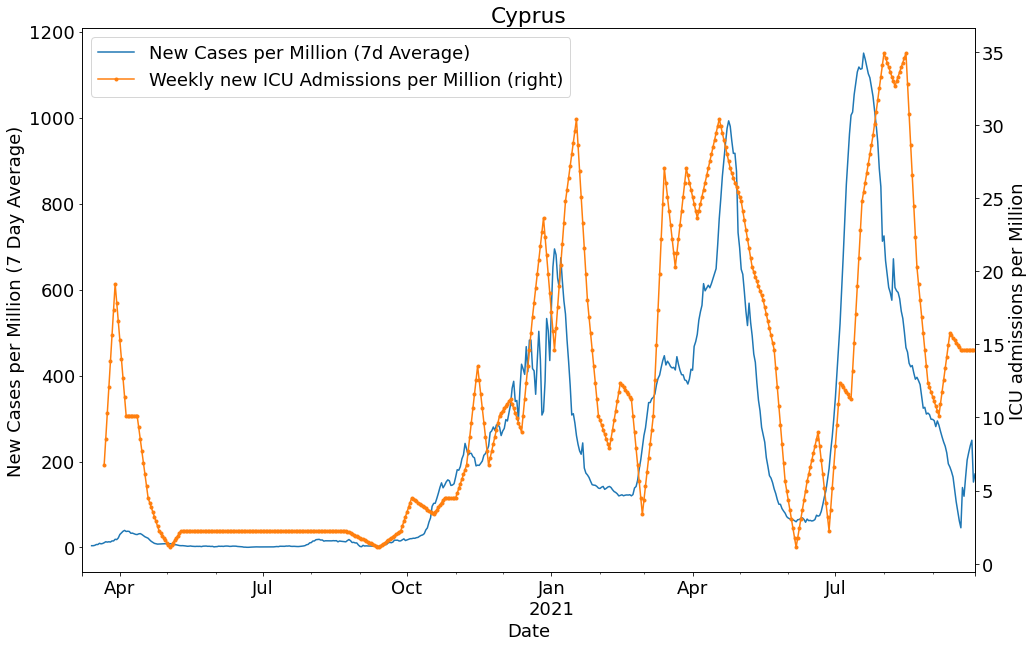

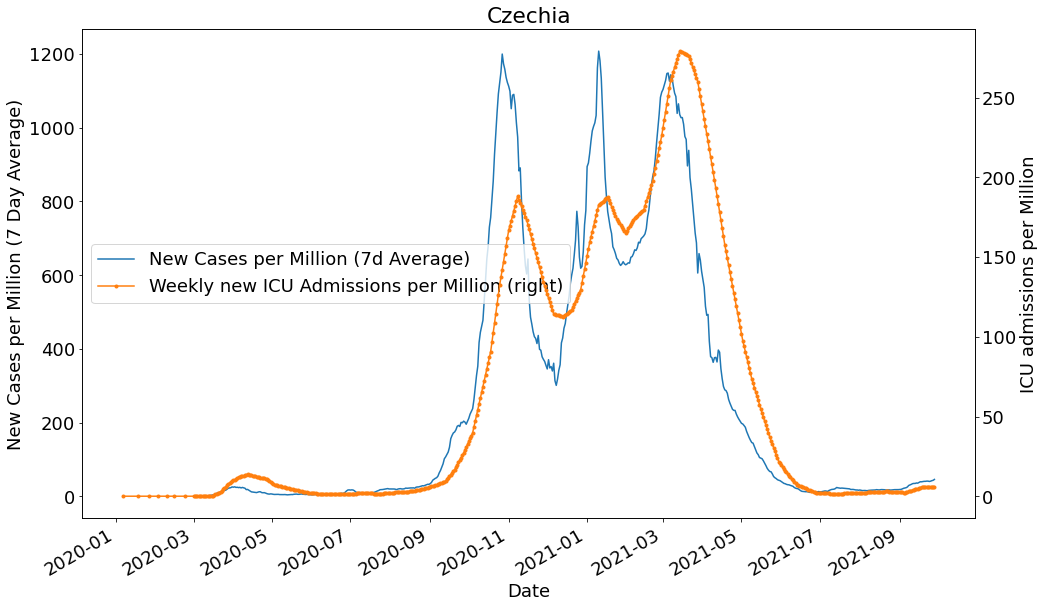

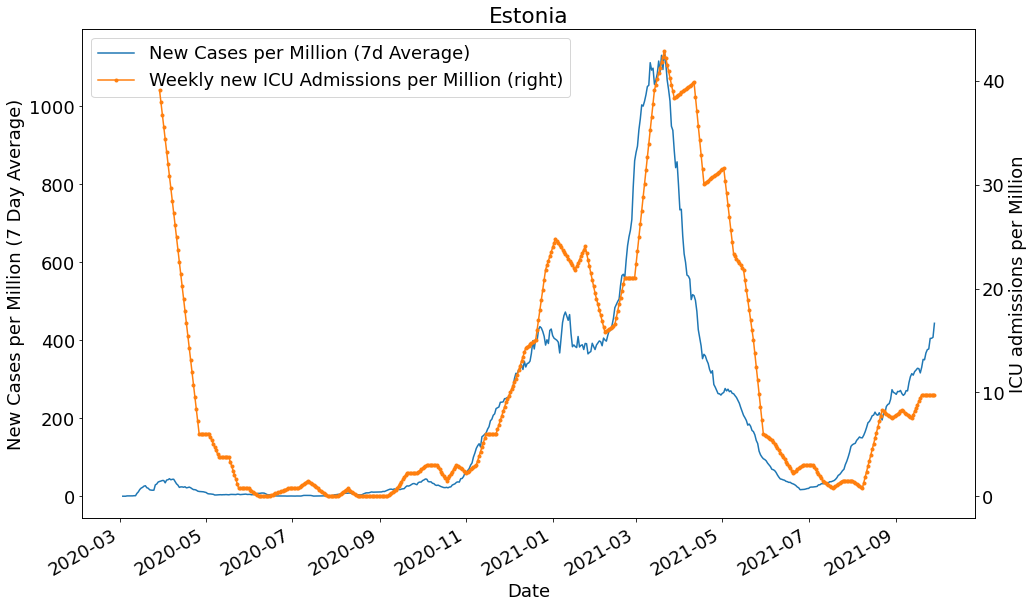

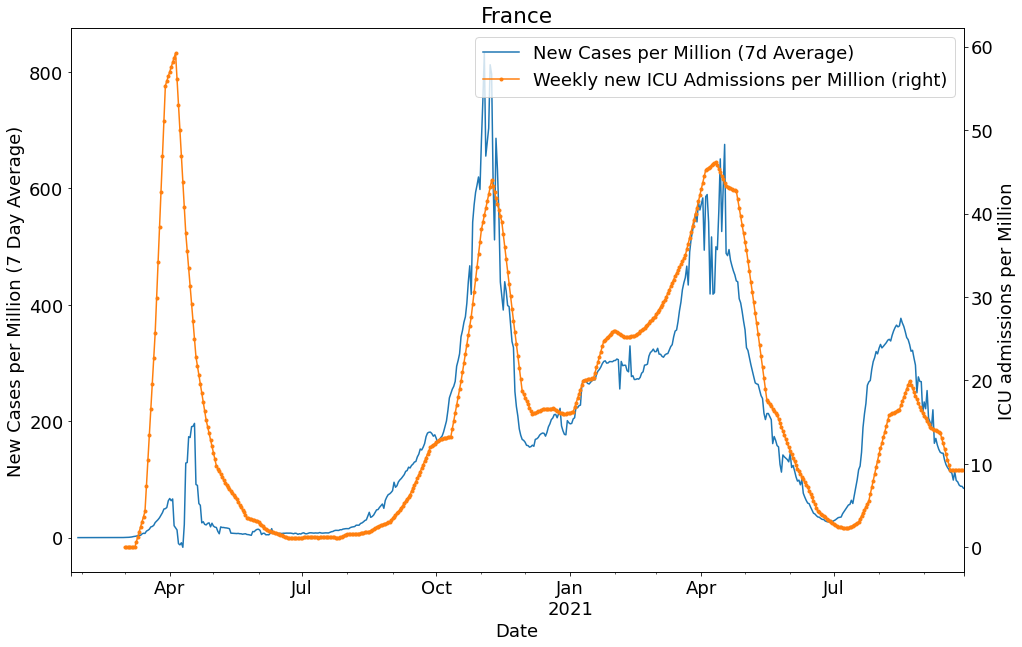

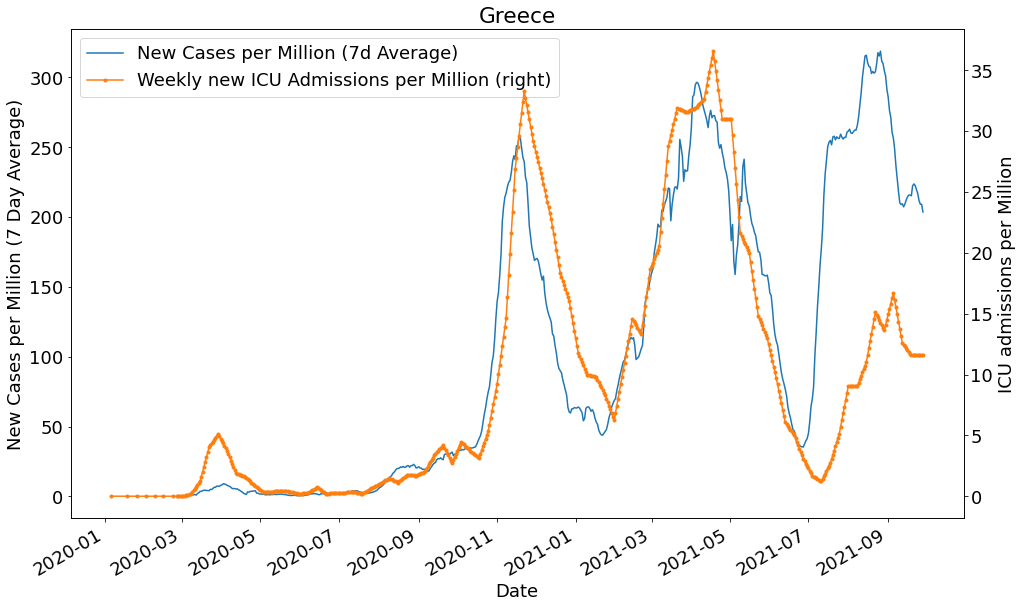

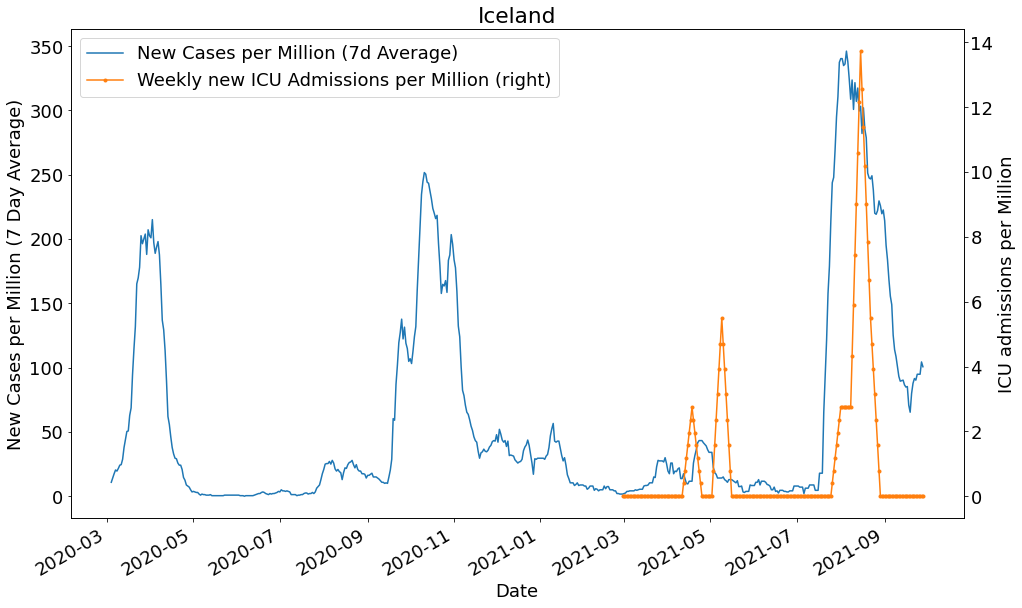

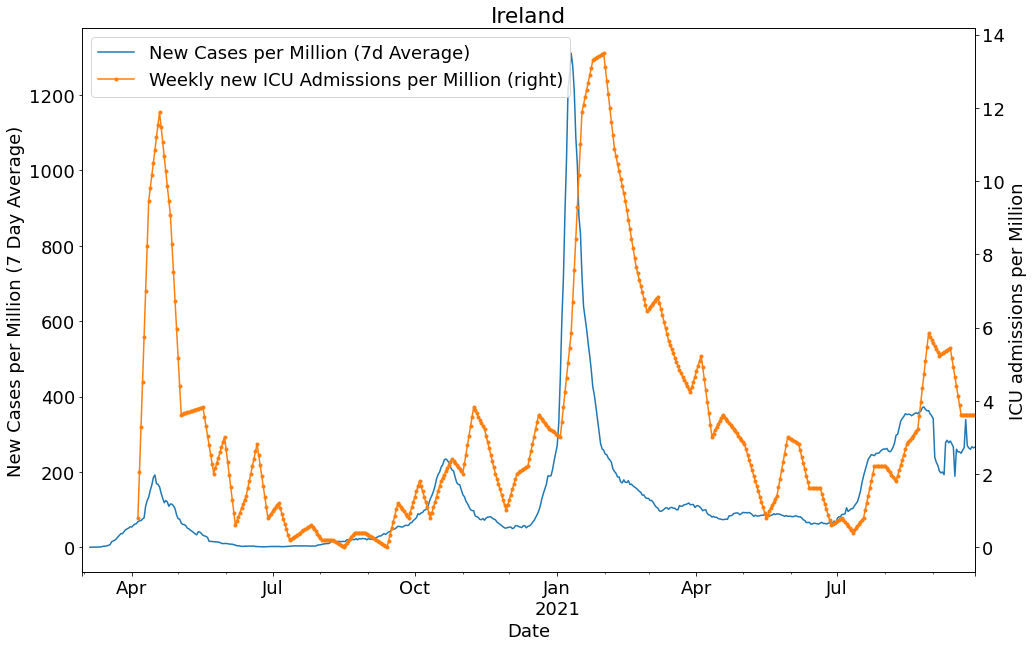

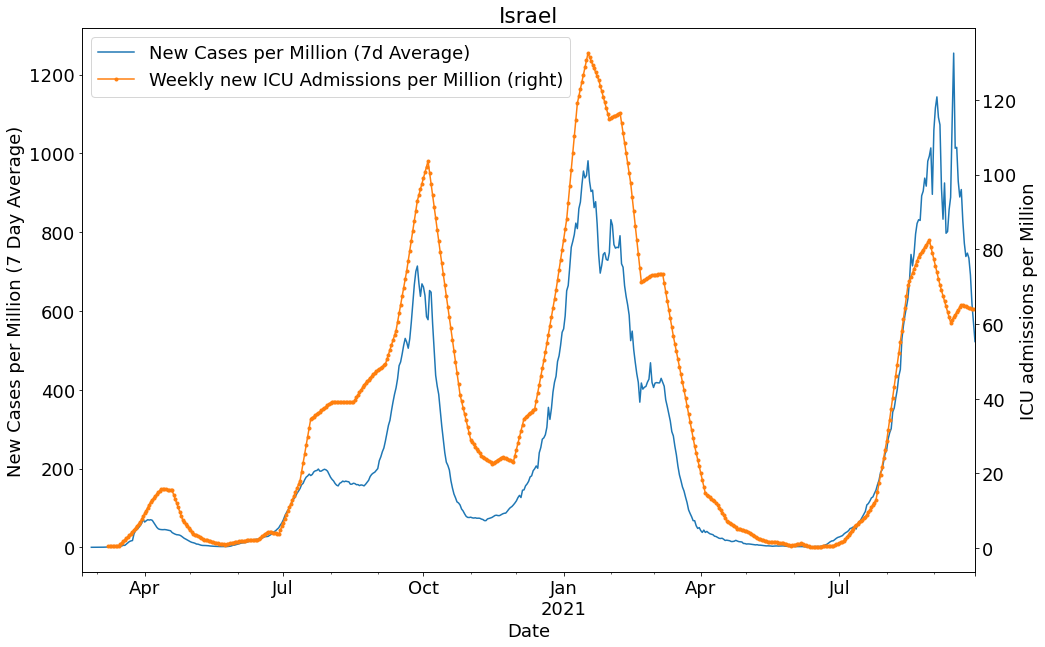

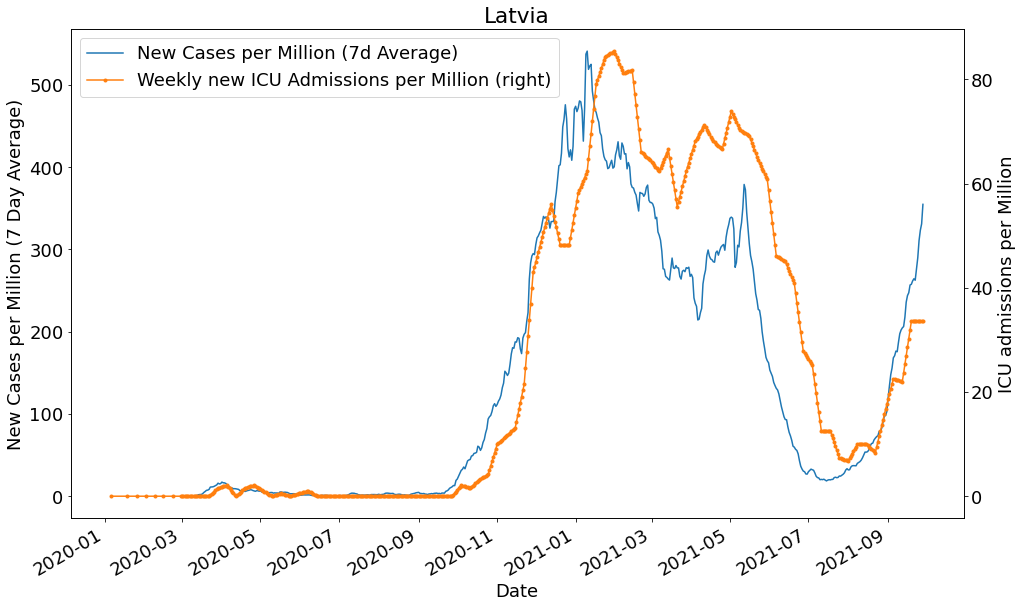

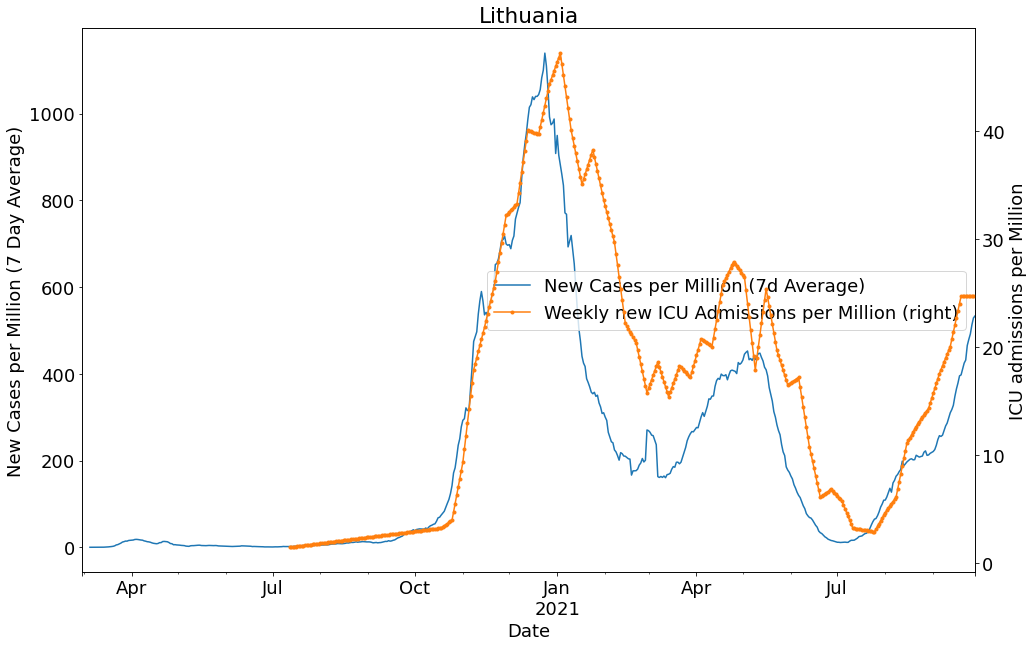

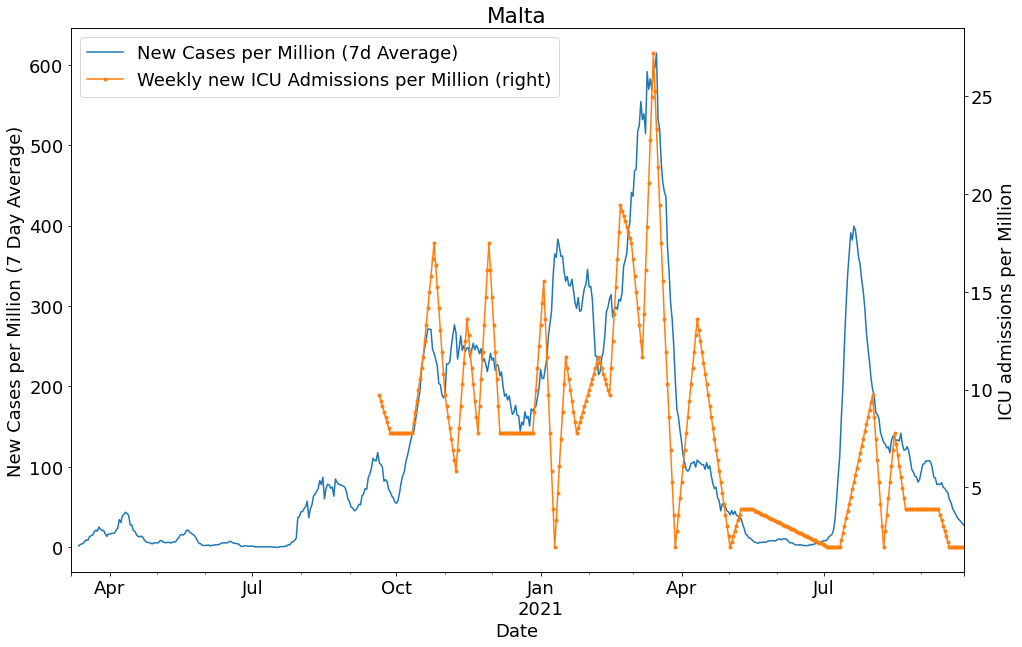

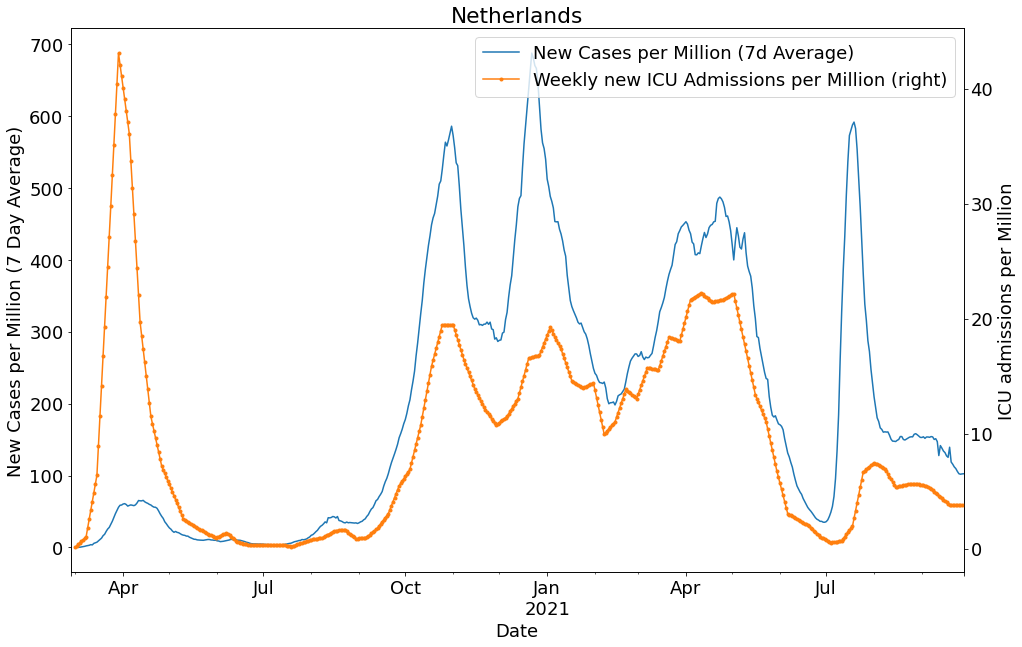

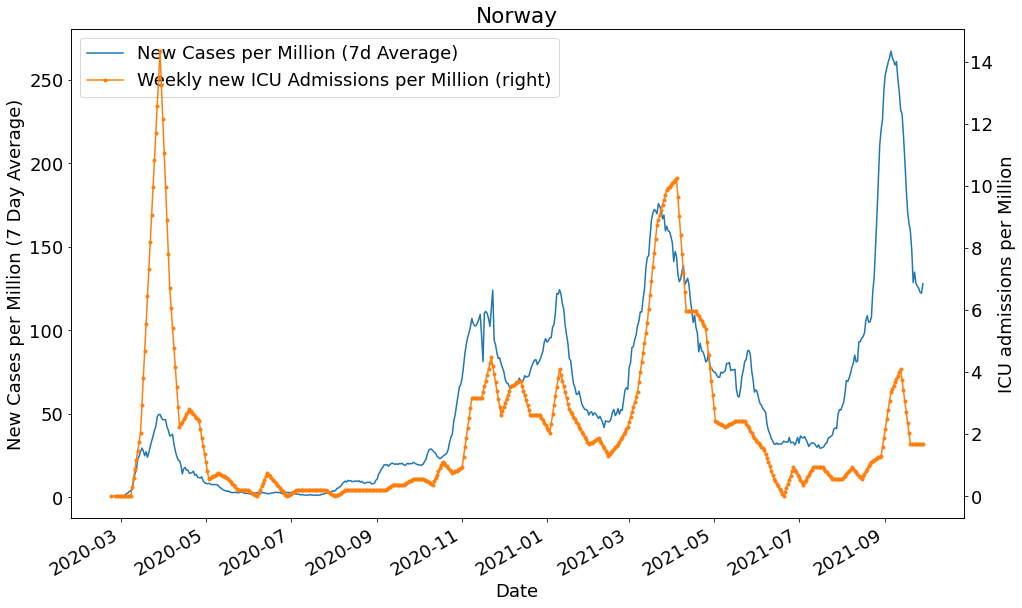

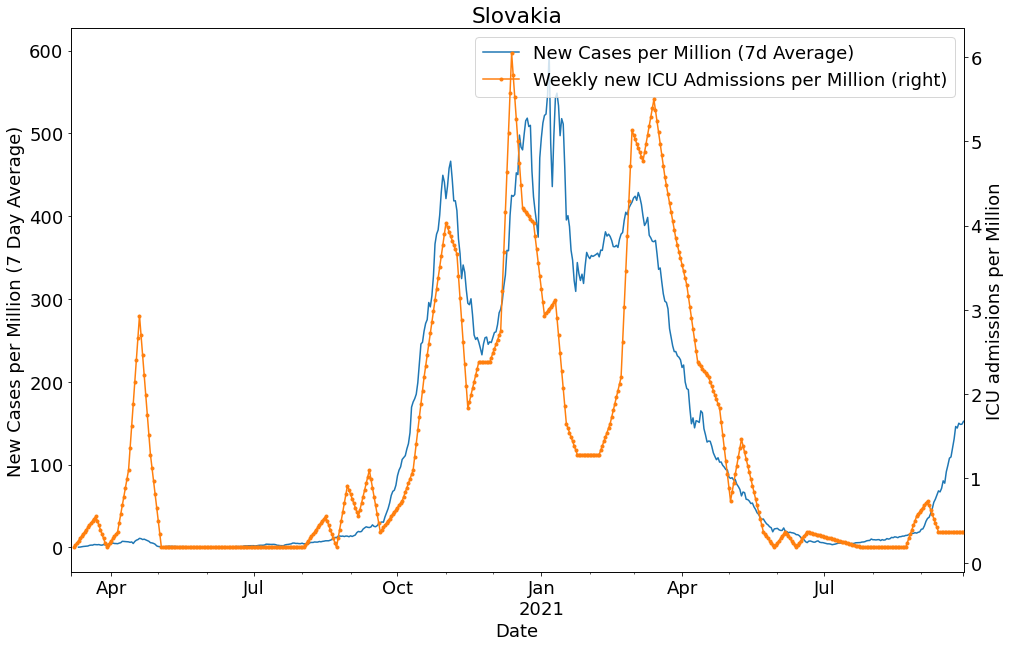

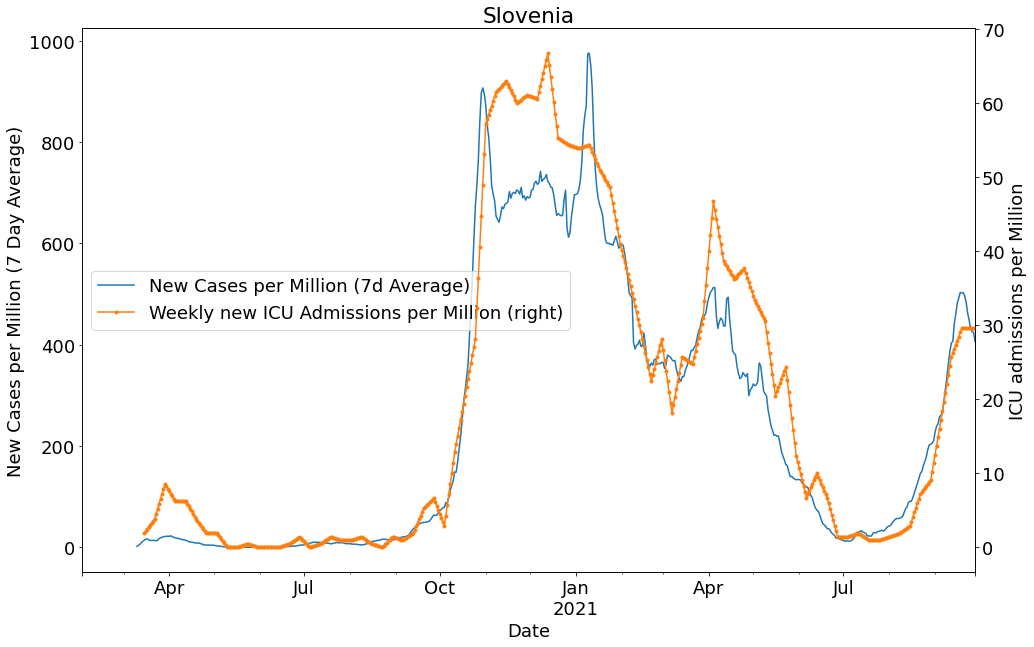

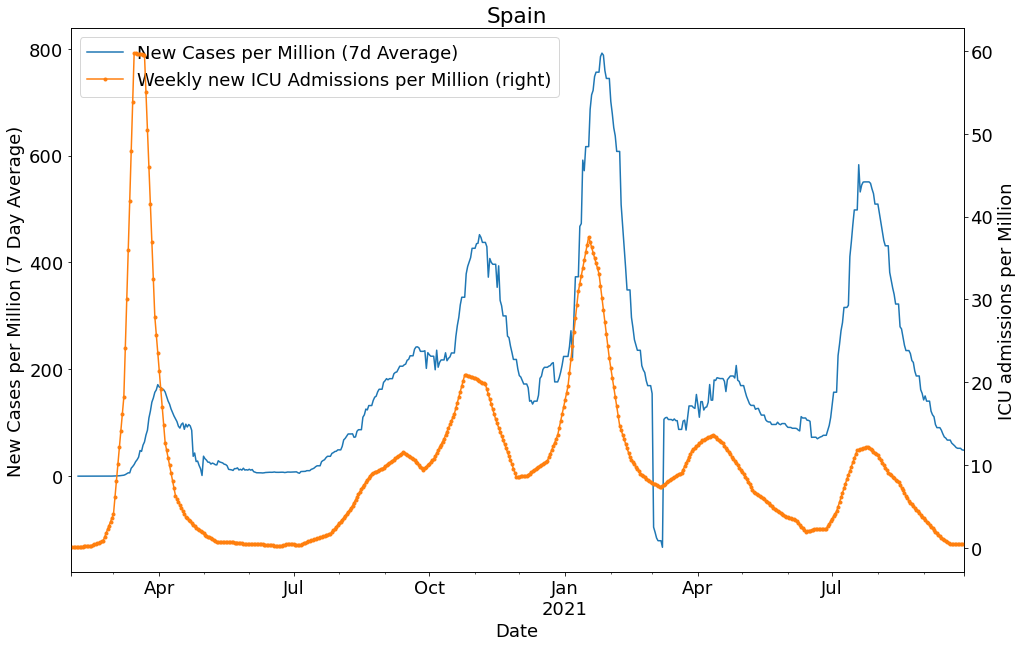

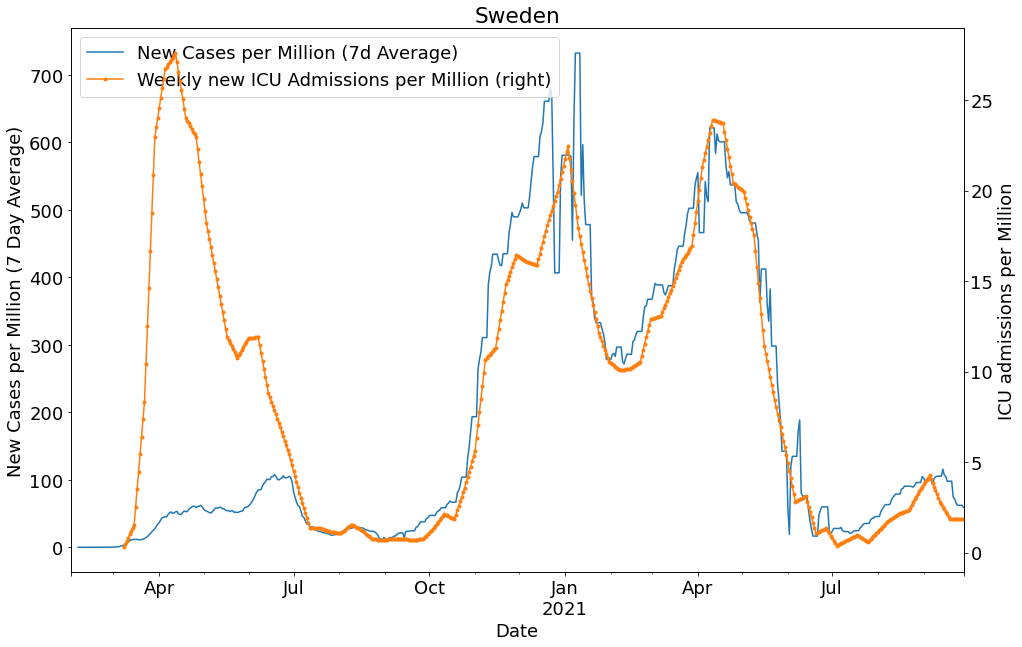

In [10]:
# Plot ICU ADMISSIONS and smoothed case numbers for these countries

for country in icu_admissions_countries:
    df = cases_icu_grouped.get_group(country)
    # interpolate weekly ICU admission linearly
    df.interpolate(method='linear', inplace=True)

    fig = plt.figure(figsize=(16, 10))
    cax = plt.gca()
    
    df.plot(x='date', y='new_cases_smoothed_per_million', kind='line', 
                  ylabel='New Cases per Million (7 Day Average)', ax=cax,
           label='New Cases per Million (7d Average)')
    df.plot(x='date', y='weekly_icu_admissions_per_million', kind='line', ax=cax,
            secondary_y=True, linestyle='solid', marker='.',
           label='Weekly new ICU Admissions per Million')
    cax.right_ax.set_ylabel('ICU admissions per Million')
    cax.set_xlabel('Date')
    cax.set_title(str(df['location'].unique()[0]))

    fig.savefig('fig4paper/icu_admissions/icu_admissions_' + country + '.pdf')

### ICU Occupancy

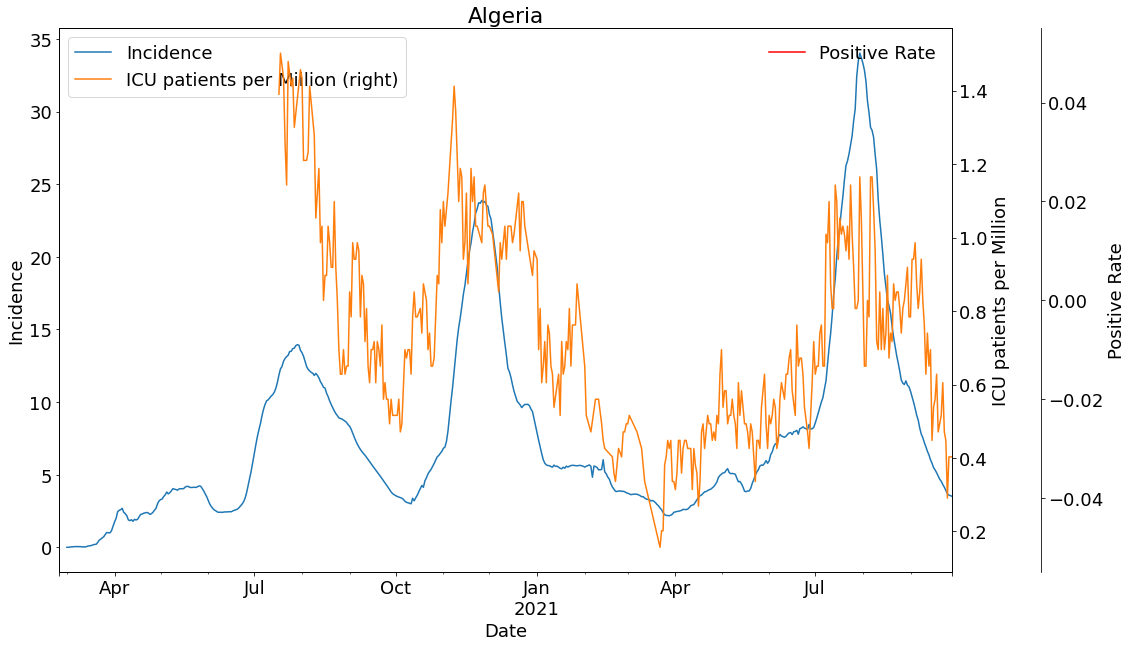

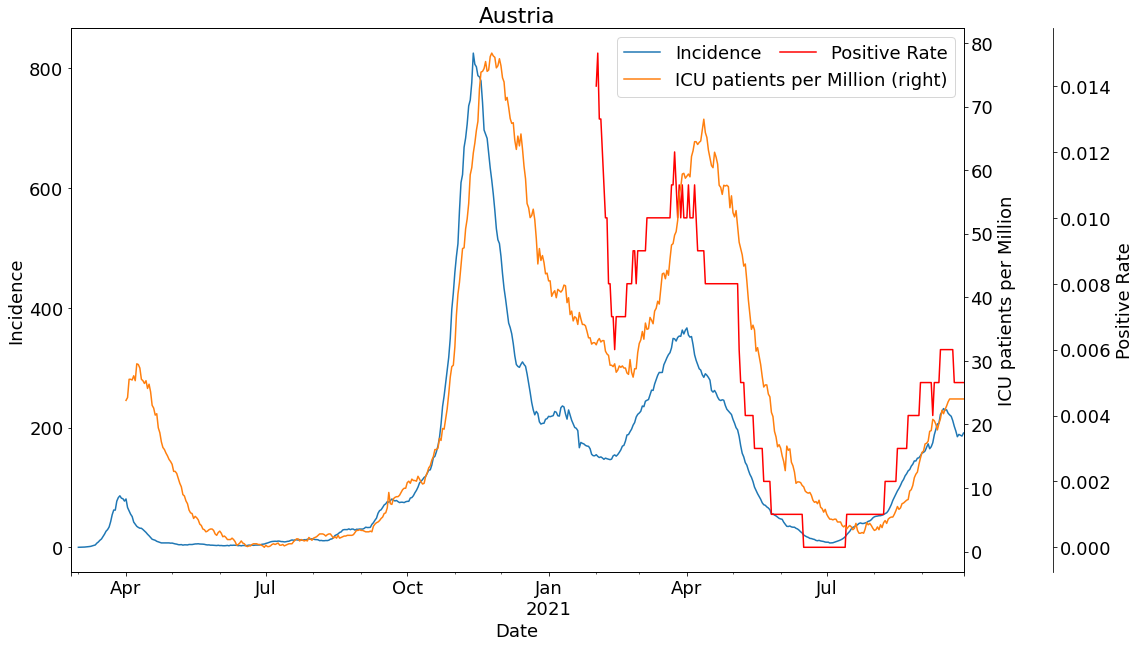

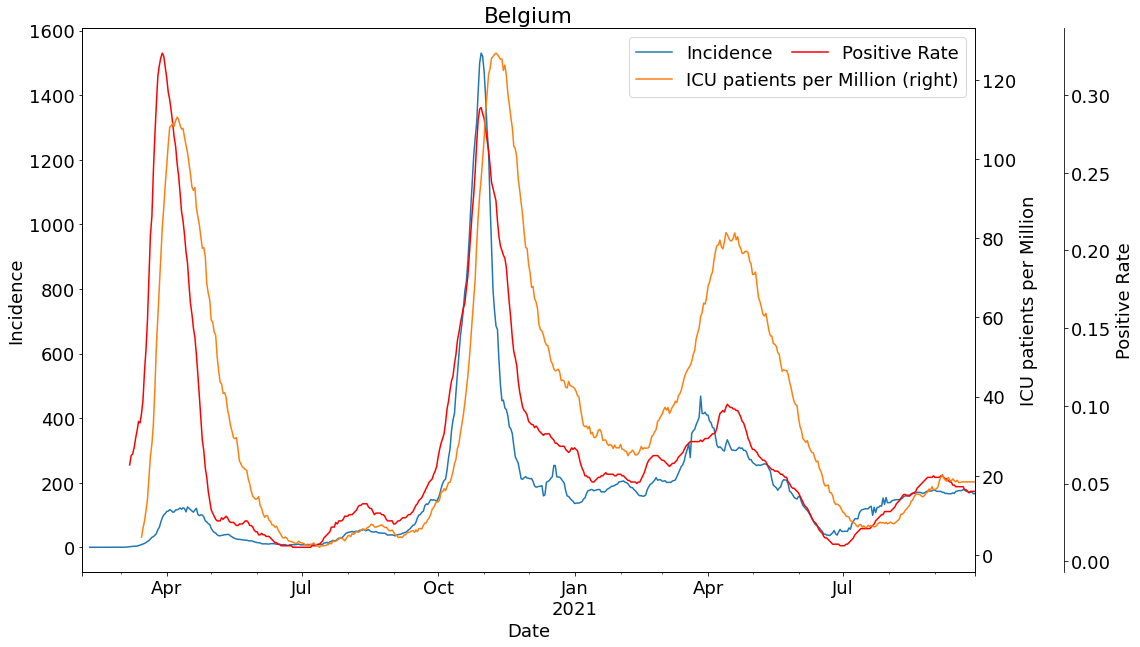

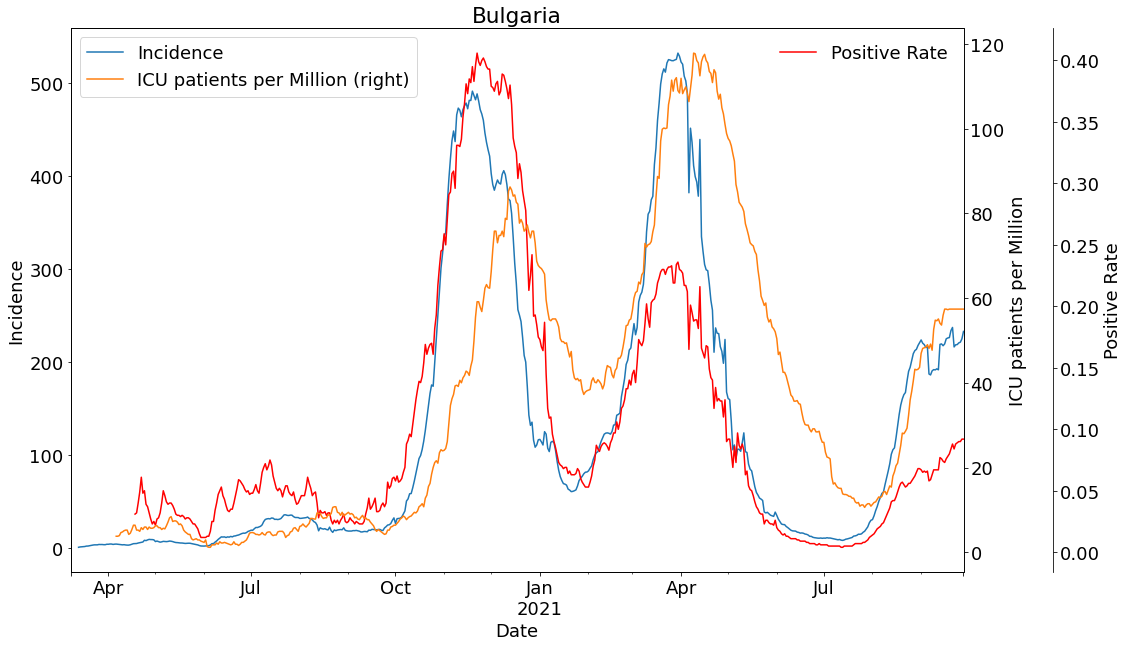

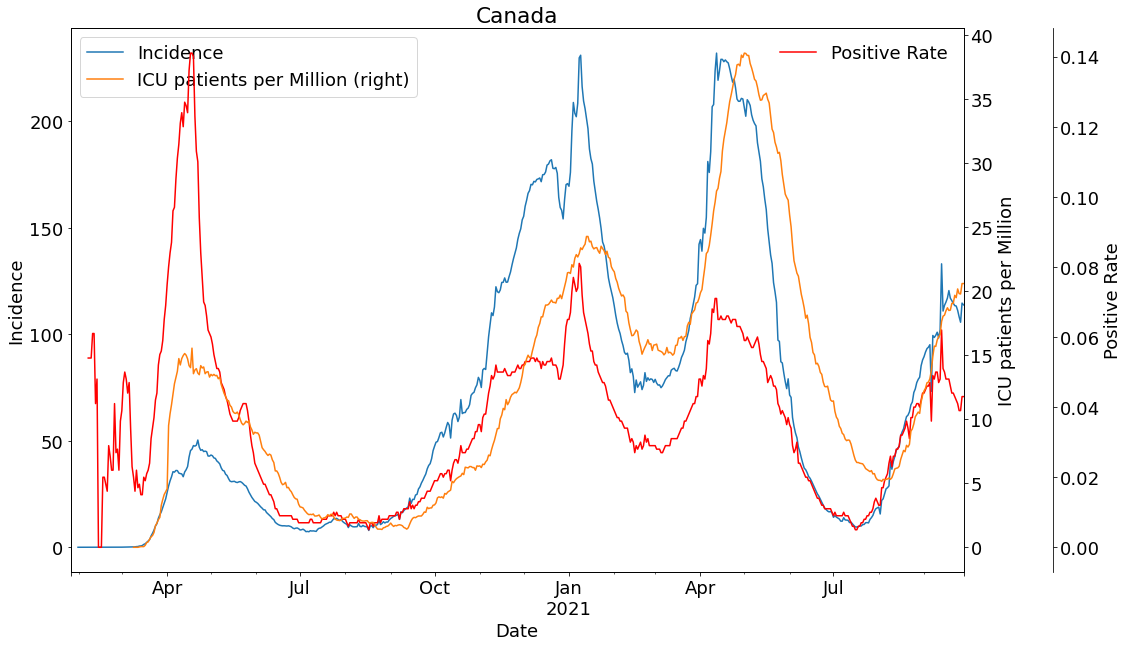

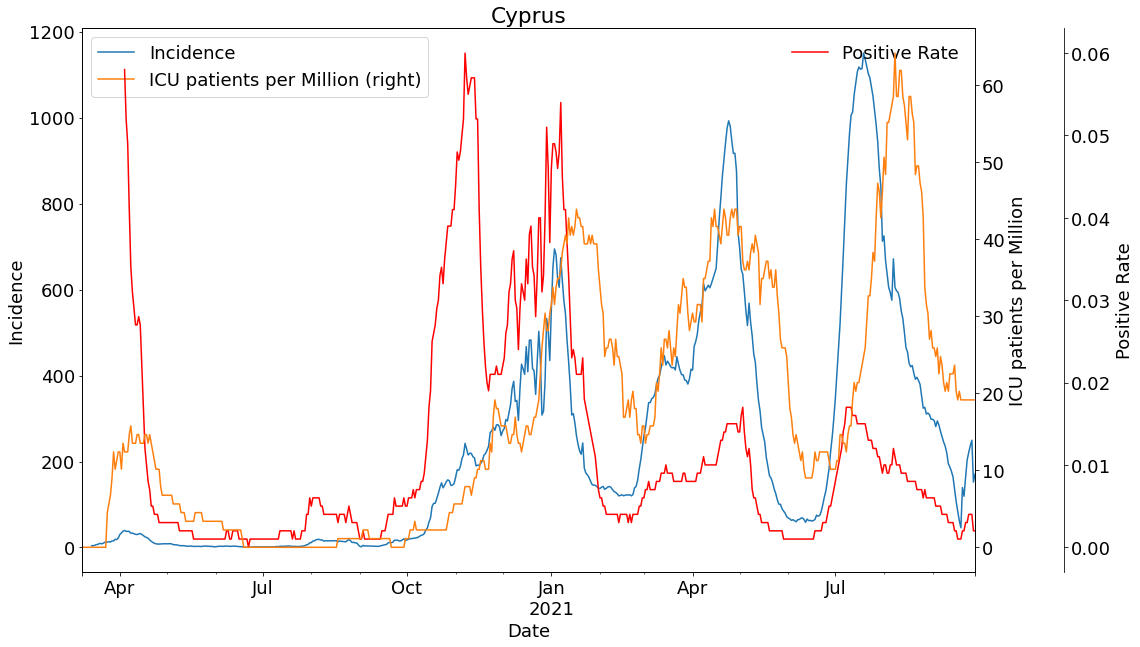

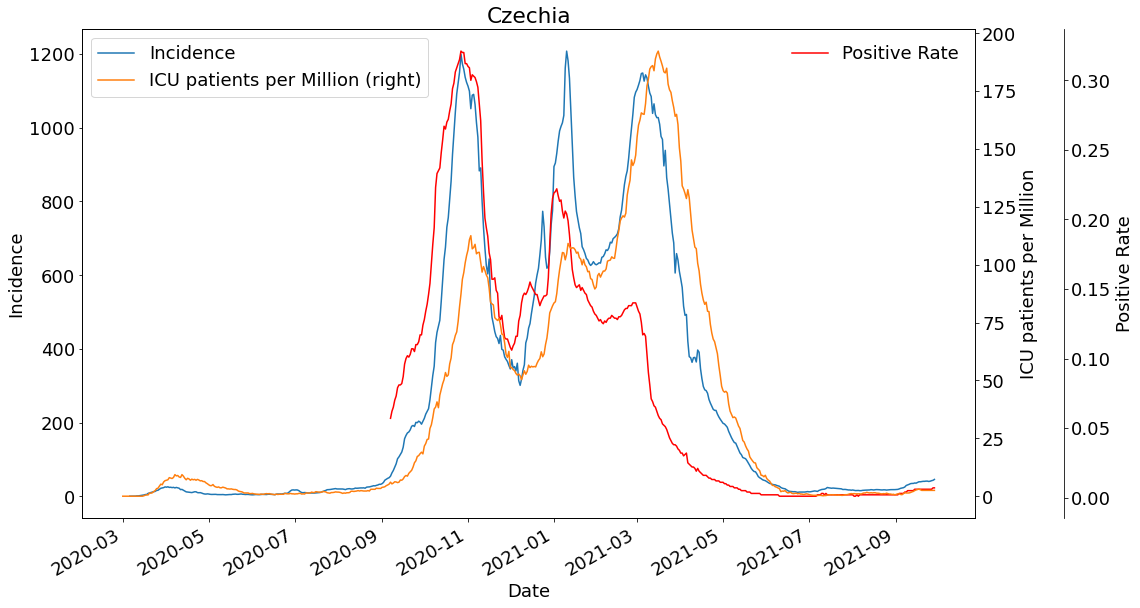

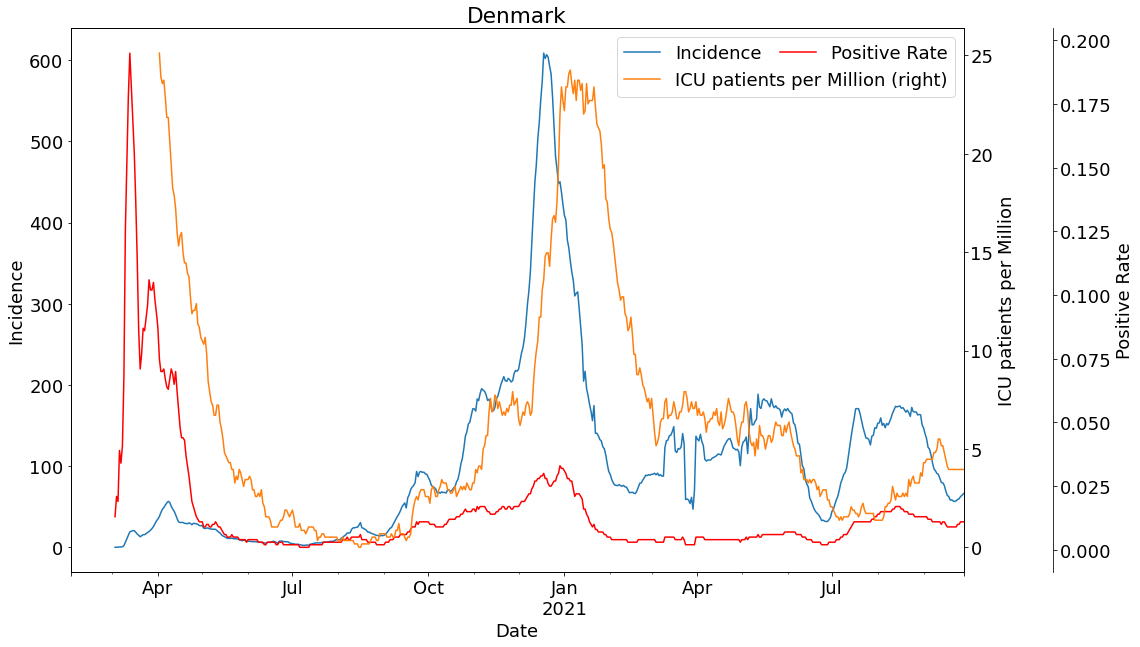

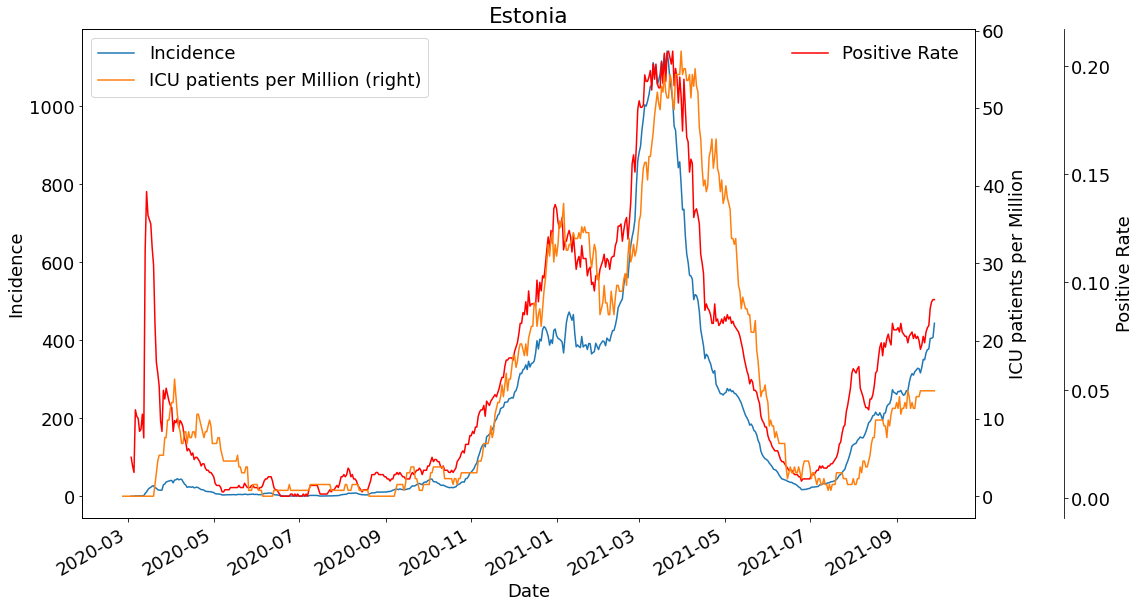

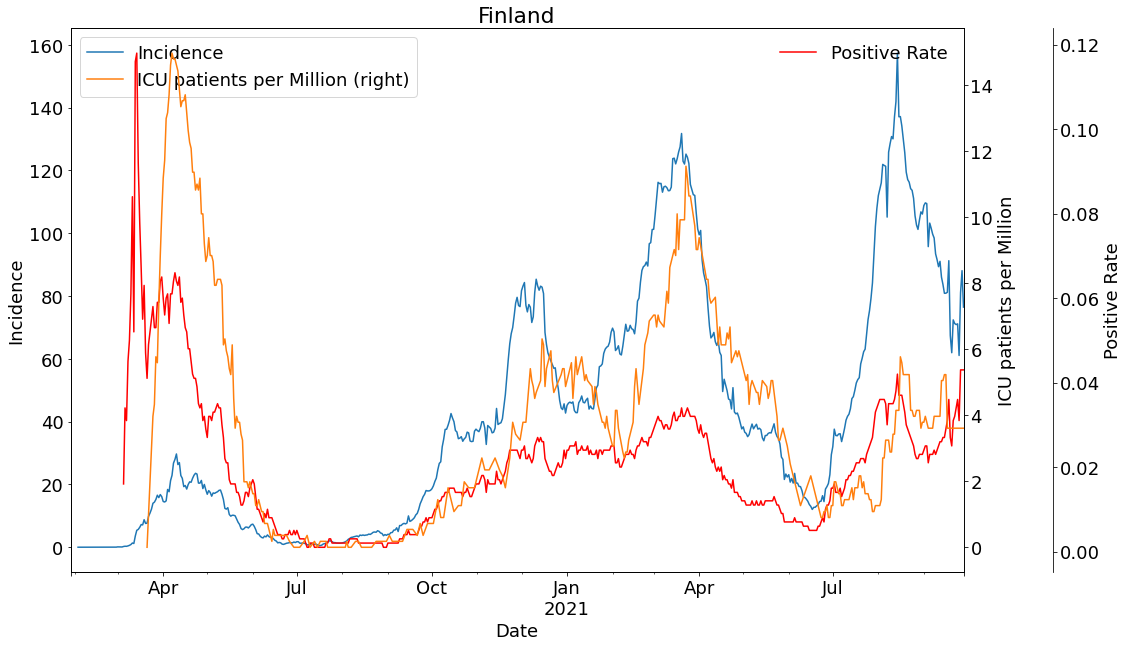

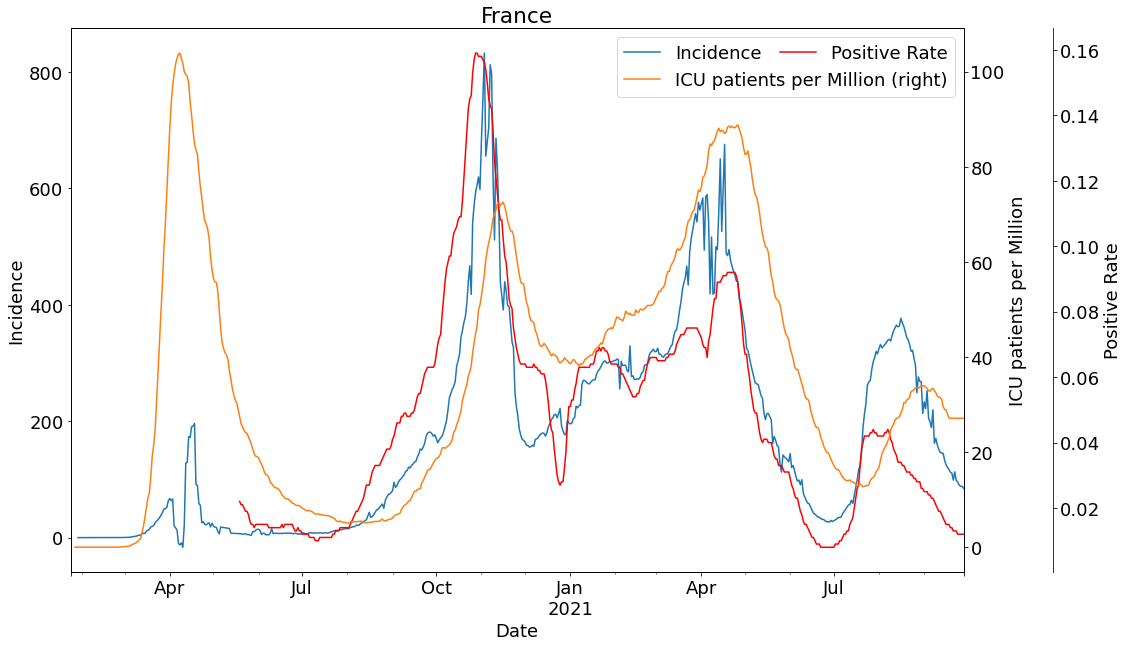

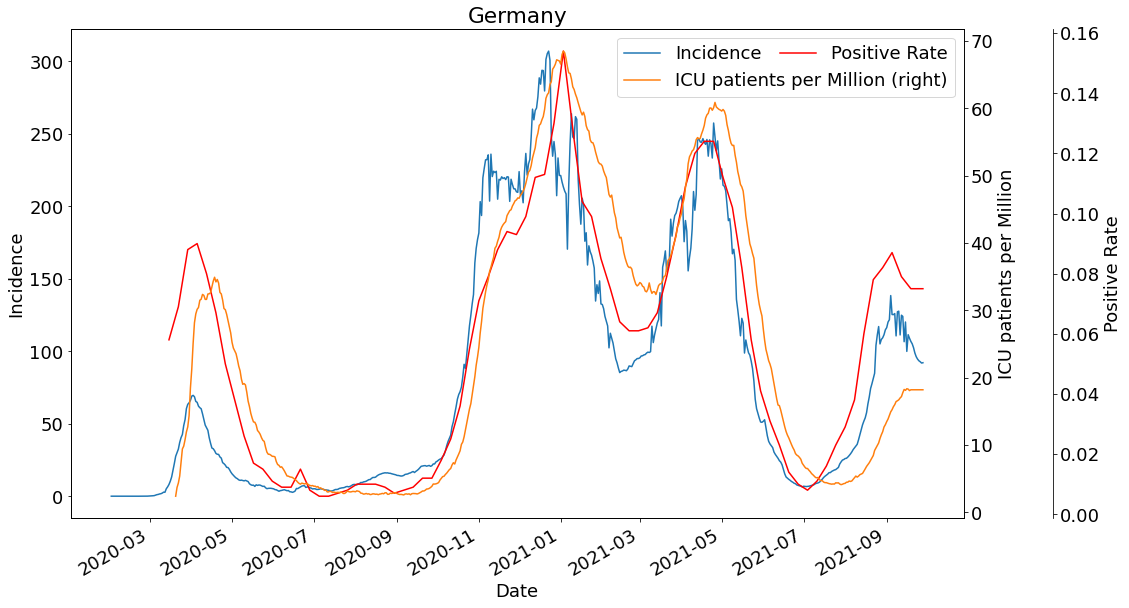

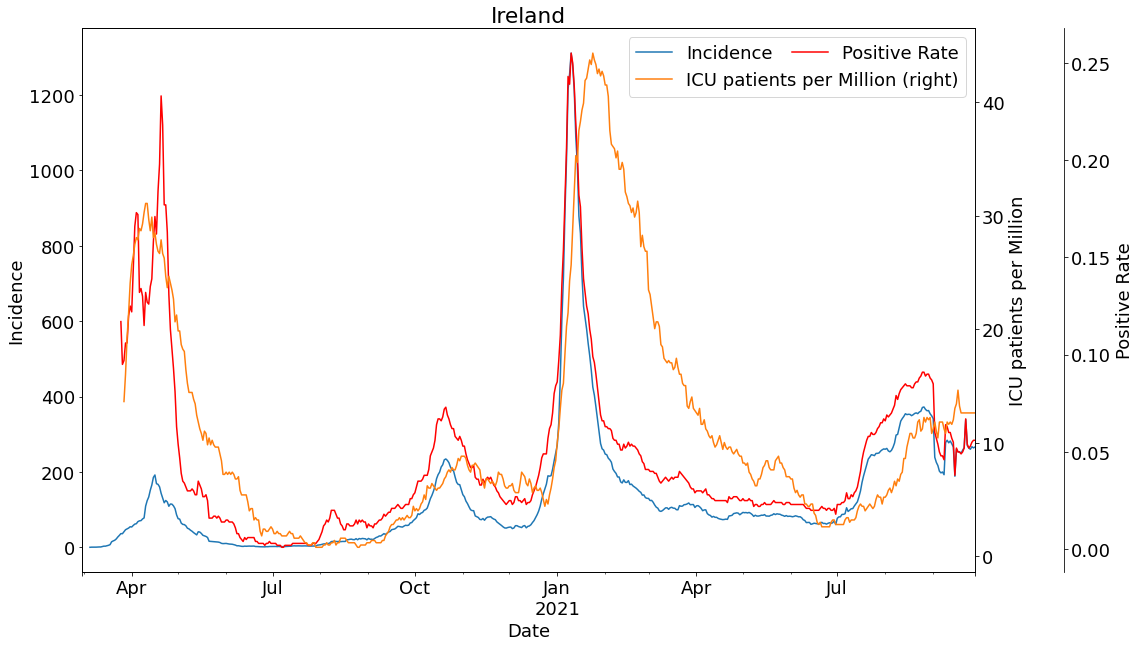

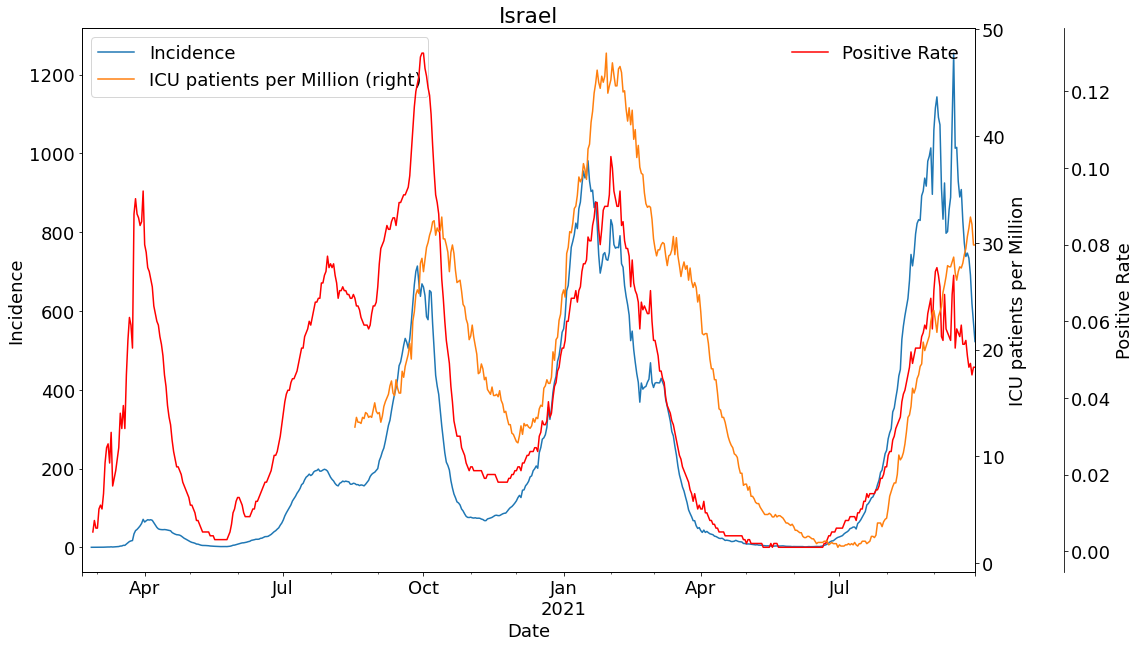

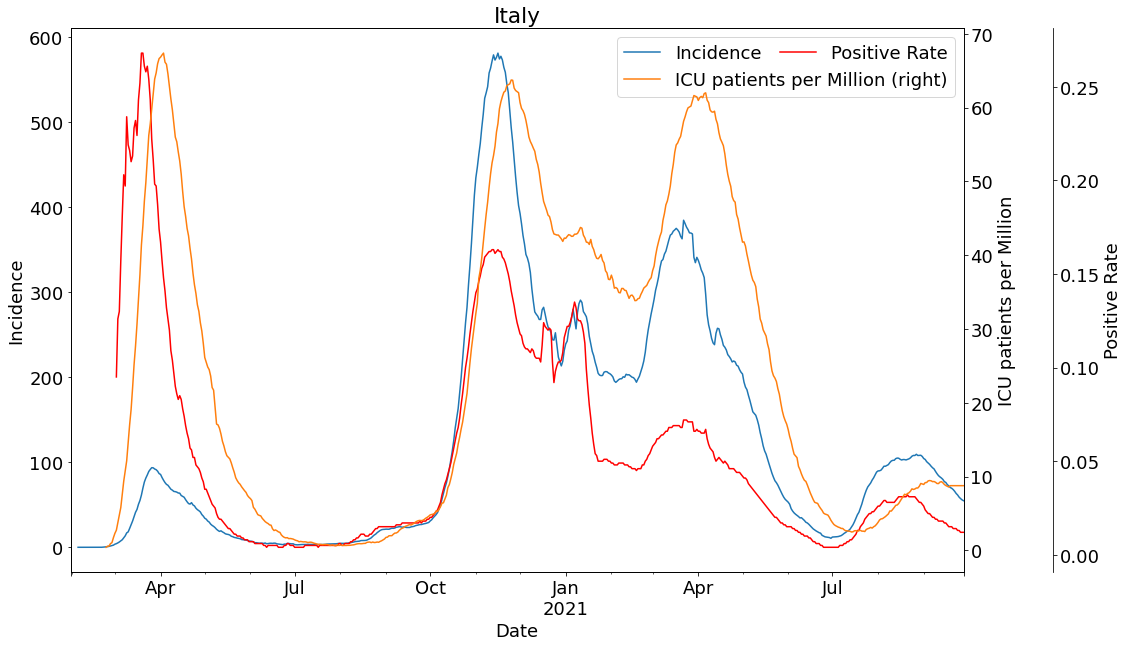

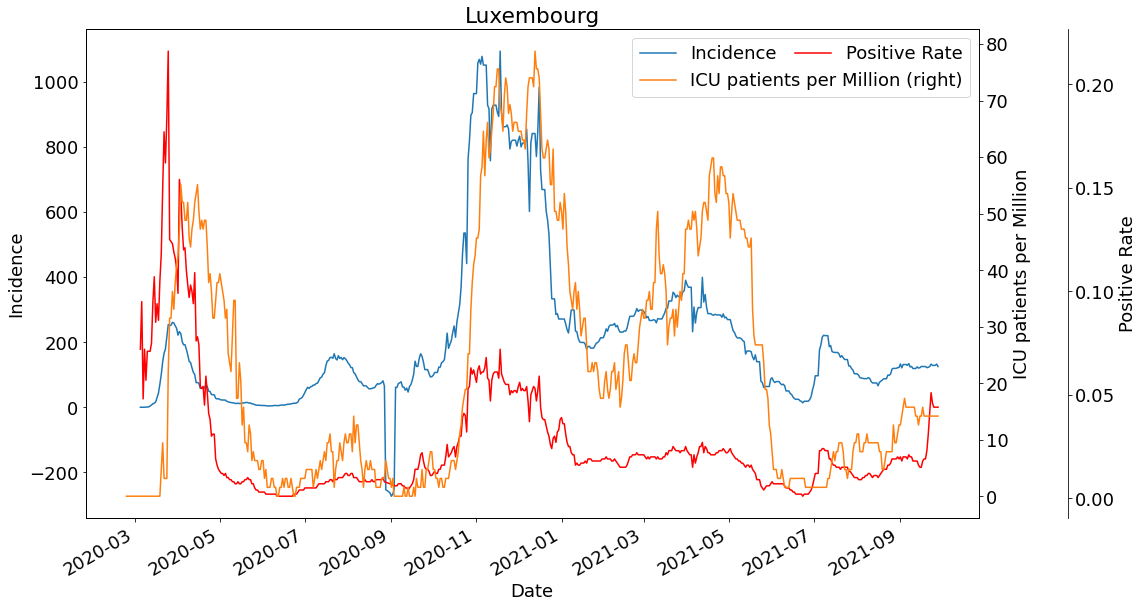

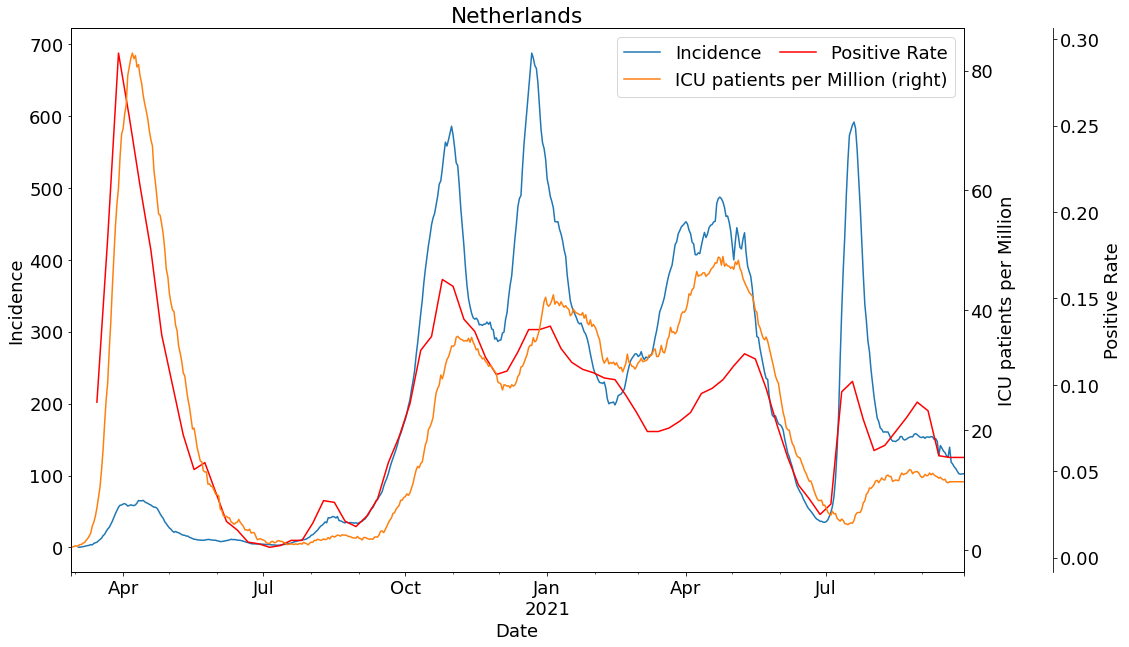

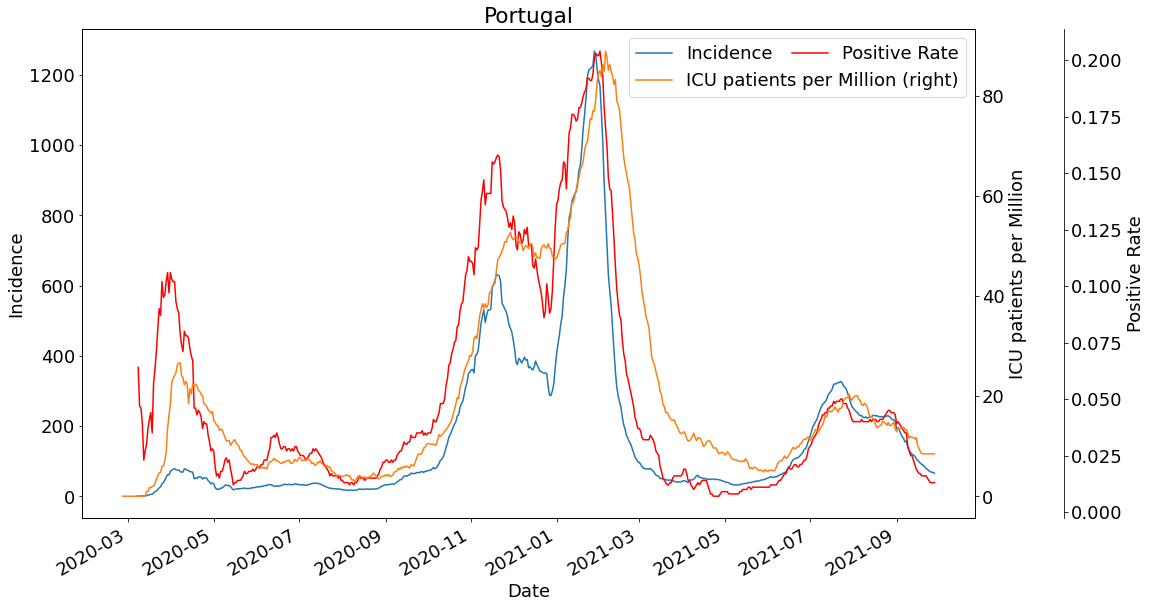

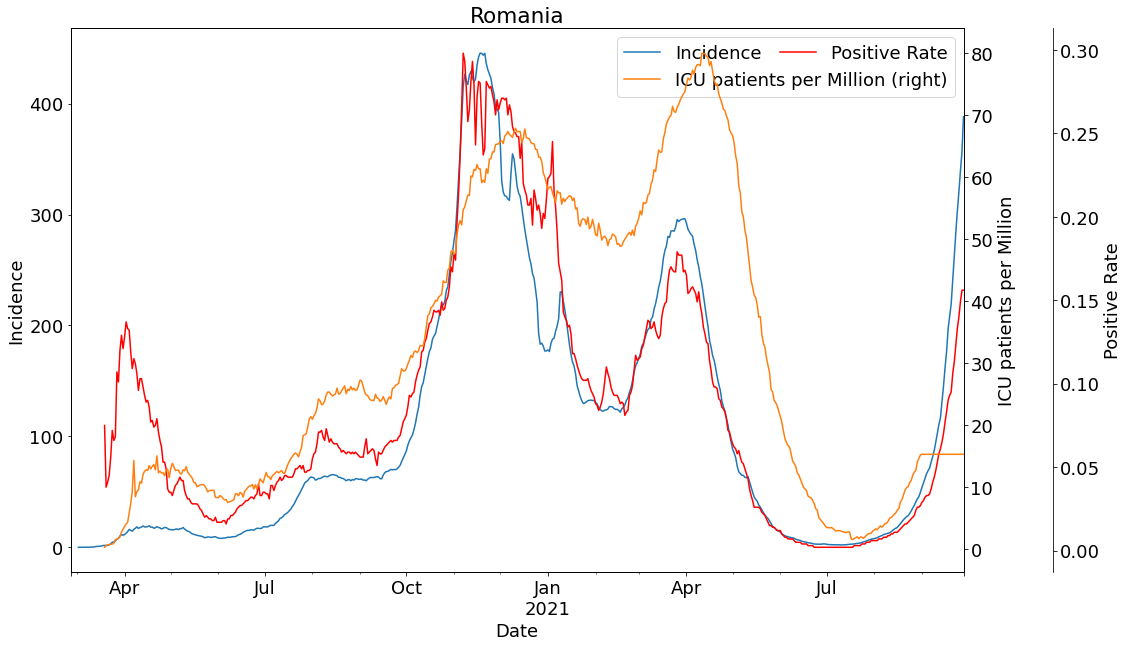

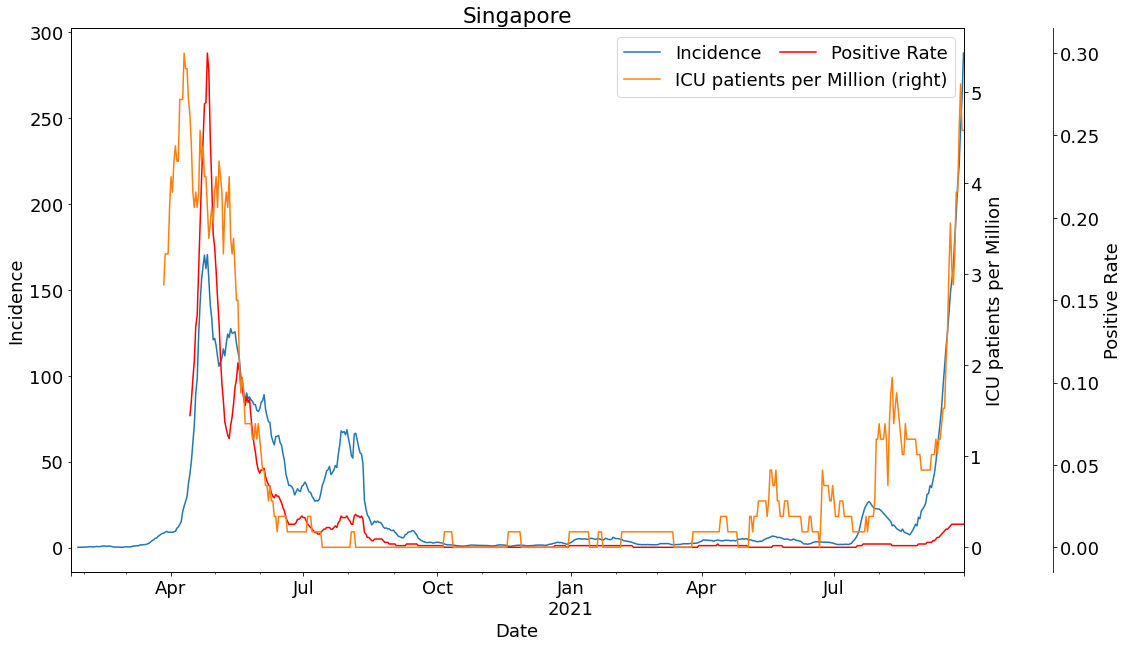

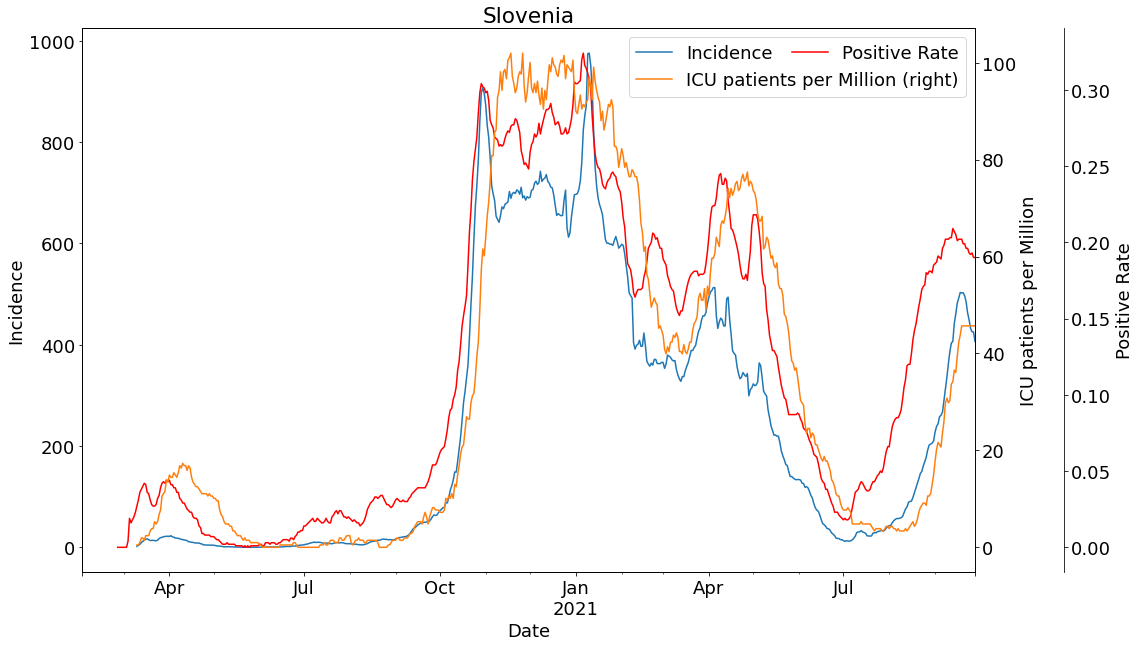

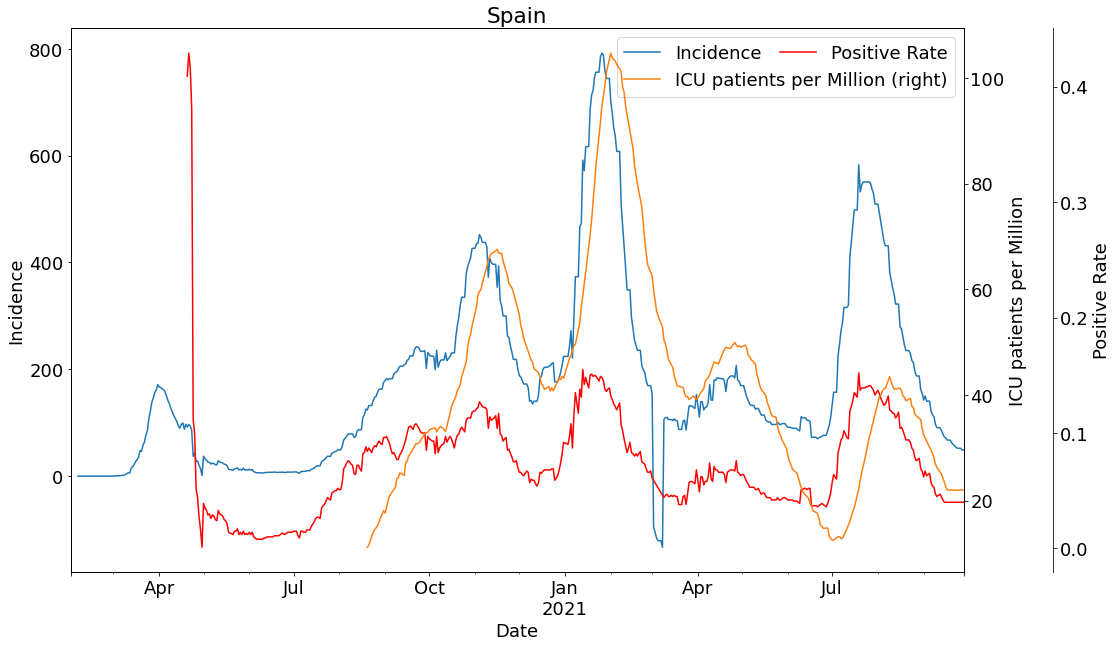

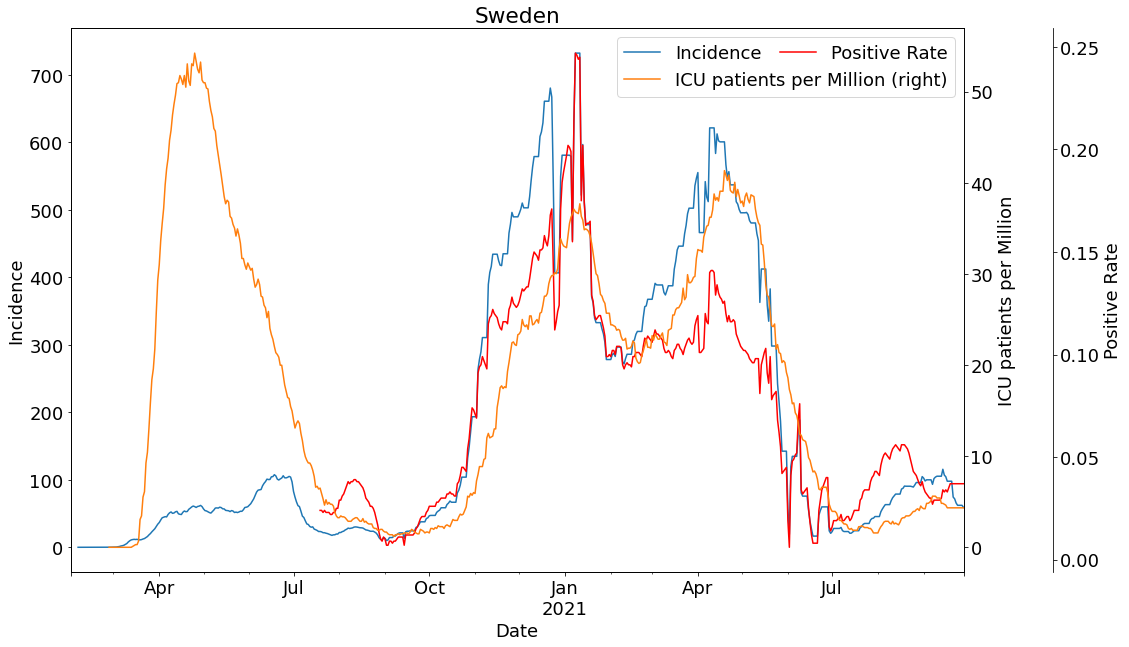

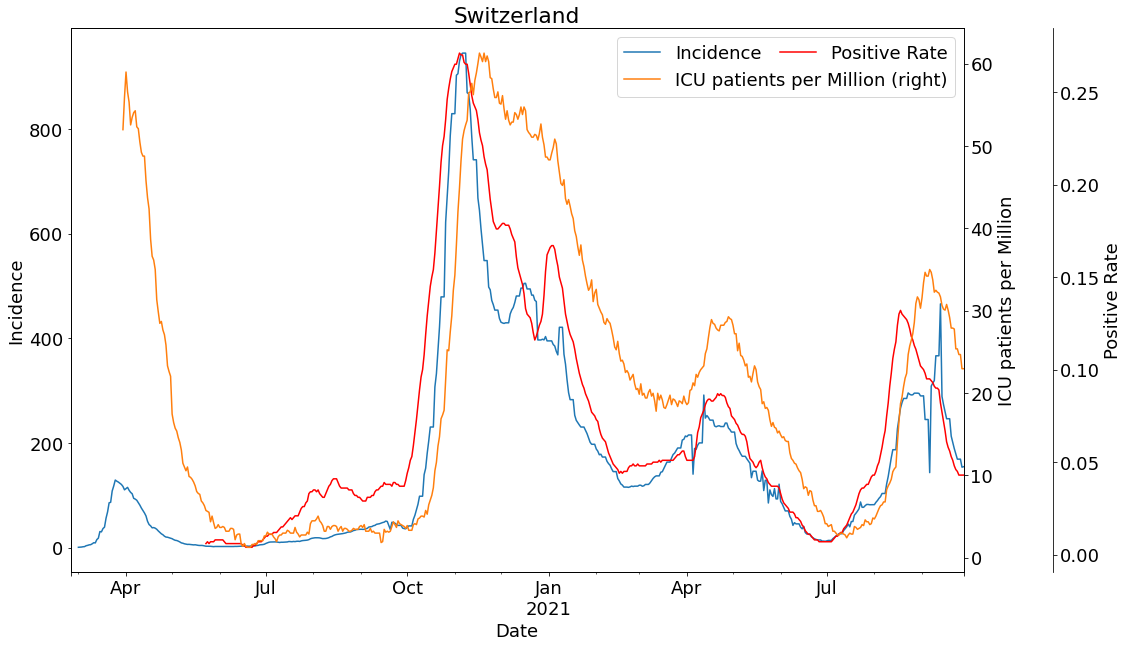

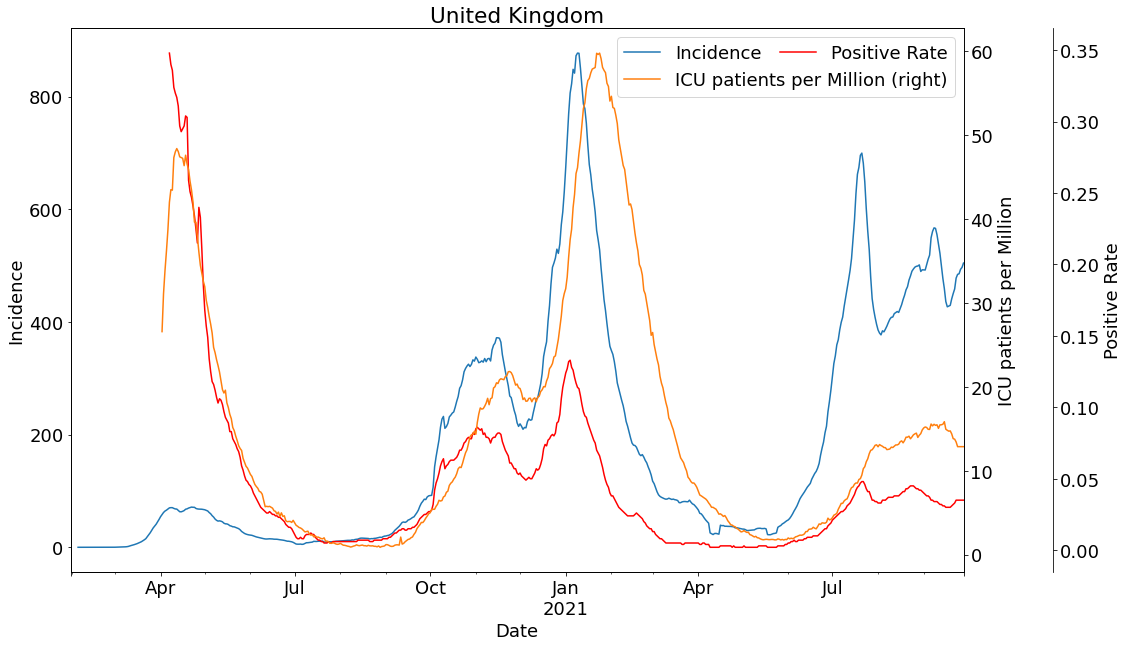

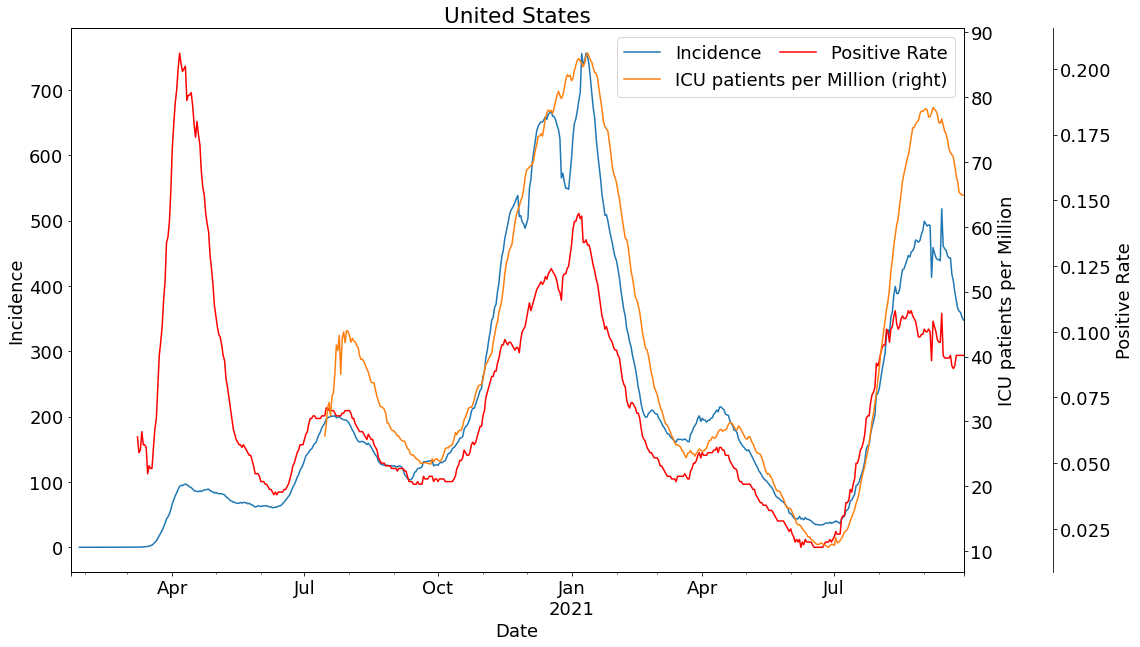

In [111]:
# Plot ICU OCCUPANCY, smoothed case numbers and positive rate

for country in icu_countries:
    df = cases_icu_grouped.get_group(country)
    # interpolate ICU occupancy linearly
    df.interpolate(method='linear', inplace=True)

    fig, ax = plt.subplots(figsize=(16,10))
    # for third variable
    ax2 = ax.twinx()
    ax2.spines['right'].set_position(('axes', 1.1))
    
    df.plot(x='date', y='new_cases_smoothed_per_million', kind='line', 
                  ylabel='Incidence', ax=ax, label='Incidence')
    df.plot(x='date', y='icu_patients_per_million', kind='line', ax=ax,
            secondary_y=True, linestyle='solid',
           label='ICU patients per Million')
    df.plot(x='date', y='positive_rate', kind='line', ax=ax2, color='red',
           label='Positive Rate', ylabel='Positive Rate')
    
    ax.set_title(str(df['location'].unique()[0]))
    ax.right_ax.set_ylabel('ICU patients per Million')
    ax.set_xlabel('Date')
    ax2.legend(frameon=False)
    
    fig.savefig('fig4paper/icu_occupancy/icu_occupancy_' + country + '.pdf', bbox_inches='tight')

## Incidence against Positive Rate

In [13]:
# extract country specific positive rates and incidence
full_germany = full_data.loc[full_data.location == 'Germany']
full_israel = full_data.loc[full_data.location == 'Israel']

In [14]:
# define timeframes of the waves
# by visual inspection of plots above
# using Incidence
## Implementation: Add new col to df
colour_dict = {0: 'grey', 1:'blue', 2:'red', 3:'green', 4:'purple'}

## Germany
ger_waves = np.zeros_like(full_germany.location, dtype=int)

first = pd.to_datetime('2020-05-15')
second_begin = pd.to_datetime('2020-09-01')
second_end = pd.to_datetime('2021-02-15')
third_begin = pd.to_datetime('2021-02-16')
third_end = pd.to_datetime('2021-07-01')

ger_first_wave = full_germany['date'] < first
ger_waves[ger_first_wave] = 1

ger_second_wave = (second_begin < full_germany['date']) & (full_germany['date'] < second_end)
ger_waves[ger_second_wave] = 2

ger_third_wave = (third_begin < full_germany['date']) & (full_germany['date'] < third_end)
ger_waves[ger_third_wave] = 3

ger_fourth_wave = full_germany['date'] > third_end
ger_waves[ger_fourth_wave] = 4

full_germany['waves'] = [colour_dict[entry] for entry in ger_waves]

## Israel
isr_waves = np.zeros_like(full_israel.location, dtype=int)

isr_first = pd.to_datetime('2020-05-01')
isr_second_begin = pd.to_datetime('2020-06-25')
isr_second_end = pd.to_datetime('2020-11-07')
isr_third_end = pd.to_datetime('2021-04-01')
isr_fourth_begin = pd.to_datetime('2021-07-08')

isr_first_wave = full_israel['date'] < isr_first
isr_waves[isr_first_wave] = 1

isr_second_wave = (isr_second_begin < full_israel['date']) & (full_israel['date'] < isr_second_end)
isr_waves[isr_second_wave] = 2

isr_third_wave = (isr_second_end < full_israel['date']) & (full_israel['date'] < third_end)
isr_waves[isr_third_wave] = 3

isr_fourth_wave = full_israel['date'] > isr_fourth_begin
isr_waves[isr_fourth_wave] = 4

full_israel['waves'] = [colour_dict[entry] for entry in isr_waves]

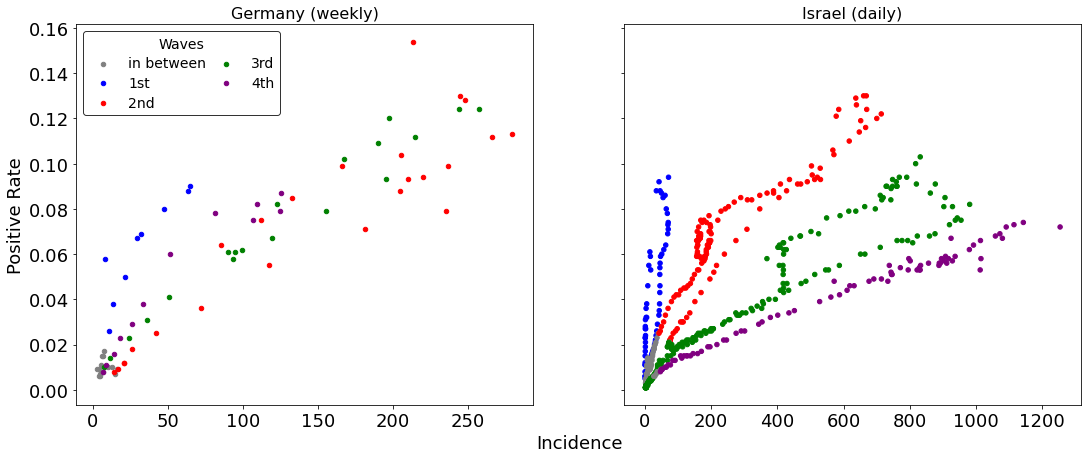

In [15]:
fig, cax = plt.subplots(1, 2, sharey=True, figsize=(18,7))

for wave_id, wave_col in colour_dict.items():
    full_germany[full_germany.waves == wave_col].plot.scatter(x='new_cases_smoothed_per_million',
                                                             y='positive_rate', xlabel=' ', ylabel='Positive Rate',
                                                             ax=cax[0], label=wave_id, c=wave_col)
cax[0].set_title('Germany (weekly)', fontsize=16)

# customize legend
handles, _ = cax[0].get_legend_handles_labels()
cax[0].legend(handles, ['in between', '1st', '2nd', '3rd', '4th'],
             ncol=2, title='Waves', fontsize=14, labelspacing=0.4,
             columnspacing=0.4, title_fontsize=14, edgecolor='black')

full_israel.plot.scatter(x='new_cases_smoothed_per_million', y='positive_rate', xlabel=' ',
                        ylabel='Positive Rate', c='waves', ax=cax[1])
cax[1].set_title('Israel (daily)', fontsize=16)

# add shared x-label
fig.text(0.48, 0.04, 'Incidence')

fig.savefig('fig4paper/posrate_incidence_both.pdf', bbox_inches='tight')

# Plot Vaccination Effect

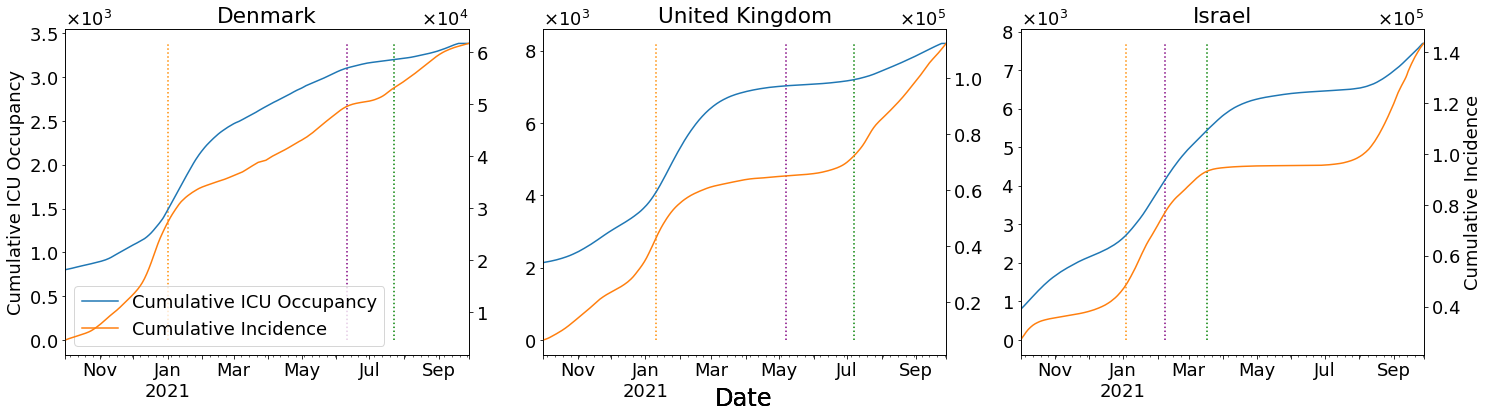

In [140]:
vax_countries = ['Denmark', 'United Kingdom', 'Israel'] # look also at: Norway

fig, ax = plt.subplots(1, 3, figsize=(21, 6))

for i in range(len(vax_countries)):
    
    # grab the country-specific data
    country = vax_countries[i]
    df = cases_icu_grouped.get_group(country)
    
    # compute cumulative ICU admissions and Cases
    cum_icu_occupancy = df.icu_patients_per_million.cumsum(skipna=True)
    df.insert(loc=0, column='cum_icu_occupancy', value=cum_icu_occupancy)
    cum_incidence = df.new_cases_smoothed_per_million.cumsum(skipna=True)
    df.insert(loc=0, column='cum_incidence', value=cum_incidence)
    
    # omit data of first wave: start plots from July 2020
    index_first_wave = df.index[df.date < pd.to_datetime('2020-10-01')]
    df.drop(index_first_wave, inplace=True)
    
    cax = ax[i] 
    df.interpolate(method='linear', inplace=True) #to plot a continuous line
    
    legend_bool = True
    if i >= 1:
        legend_bool = False
    
    df.plot(x='date', y='cum_icu_occupancy', kind='line', ax=cax,
            label='Cumulative ICU Occupancy', xlabel='', legend=legend_bool) 
   
    second_ax = df.plot(x='date', y='cum_incidence', ax=cax,
                        label='Cumulative Incidence', kind='line', secondary_y=True,
                        mark_right=False, xlabel='', legend=legend_bool)
    if i == 0:
        cax.set_ylabel('Cumulative ICU Occupancy')
    
    if i == 2:
        cax.right_ax.set_ylabel('Cumulative Incidence')
    
    # Use 1e4 notation on y axes
    cax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    cax.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
    second_ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    second_ax.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
    
    # x-labels: only every second month
    for month in cax.xaxis.get_ticklabels()[::2]:
        month.set_visible(False)
    
    
    ## Insert Vaccination Milestones
    vax = df.people_fully_vaccinated_per_hundred
    
    # First Dose: use first non-NA entry
    first_dose_idx = np.where(~vax.isna())[0][0]
    first_dose_date = df.date.iloc[first_dose_idx]  

    milestone_dates = [first_dose_date]
    
    percentiles = [25, 50]
    for perc in percentiles:
        perc_date = df.date.loc[vax > perc].iloc[0]
        milestone_dates.append(perc_date)
   
    # Add dotted lines to plot
    milestone_cols = ['darkorange', 'purple', 'green']
    cax.vlines(x=milestone_dates, linestyles='dotted', color=milestone_cols,
               ymin=0, ymax=df.cum_icu_occupancy.max(),
               label='milestones')
        
    
    cax.set_title(country)    
    
    fig.text(0.48, 0.03, 'Date', fontsize=24)
    plt.tight_layout()
    fig.savefig('fig4paper/vax_effect.pdf', bbox_inches='tight')